<a href="https://colab.research.google.com/github/Kunjanmalik19/AskAway-main-doubt-solving-app/blob/main/tri-guard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!/usr/bin/env python3
"""
Combined LLM Hallucination Detection System for Google Colab
All functionality in one file - just run this cell!
"""
import nltk
nltk.download('punkt_tab')
import os
import json
import logging
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple, Optional, Any
from dataclasses import dataclass
from collections import defaultdict
import re
import time
import random
from pathlib import Path

# Install required packages if not available
def install_requirements():
    """Install required packages"""
    import subprocess
    import sys

    packages = [
        'transformers', 'torch', 'datasets', 'scikit-learn',
        'nltk', 'spacy', 'textblob', 'sentence-transformers',
        'accelerate', 'evaluate', 'wandb', 'tqdm', 'matplotlib',
        'seaborn', 'plotly', 'dash', 'dash-bootstrap-components'
    ]

    for package in packages:
        try:
            __import__(package)
            print(f"✅ {package} already installed")
        except ImportError:
            print(f"📦 Installing {package}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"✅ {package} installed")

# Install packages
print("🔧 Installing required packages...")
install_requirements()

# Download NLTK data
try:
    import nltk
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    print("✅ NLTK data downloaded")
except:
    print("⚠️ NLTK data download failed")

# Download spaCy model
try:
    import spacy
    try:
        nlp = spacy.load("en_core_web_sm")
        print("✅ spaCy model loaded")
    except OSError:
        print("📥 Downloading spaCy model...")
        import subprocess
        subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"],
                      capture_output=True, text=True)
        nlp = spacy.load("en_core_web_sm")
        print("✅ spaCy model downloaded and loaded")
except Exception as e:
    print(f"⚠️ spaCy setup failed: {e}")

# ============================================================================
# CORE HALLUCINATION DETECTOR
# ============================================================================

@dataclass
class DetectionResult:
    """Result of hallucination detection analysis"""
    hallucination_probability: float
    confidence_score: float
    detected_issues: List[str]
    metrics: Dict[str, float]
    recommendations: List[str]
    token_analysis: Optional[List[Dict[str, Any]]] = None
    flags: Optional[List[Dict[str, Any]]] = None

class HallucinationDetector:
    """Comprehensive LLM hallucination detection system"""

    def __init__(self):
        self.uncertainty_phrases = [
            "i think", "i believe", "possibly", "maybe", "perhaps", "might be",
            "could be", "seems like", "appears to", "i'm not sure", "i don't know",
            "it's unclear", "it's possible", "may indicate", "could suggest",
            "potentially related", "somewhat", "kind of", "sort of", "roughly",
            "approximately", "around", "about", "estimate", "guess"
        ]

        self.overconfidence_phrases = [
            "definitely", "absolutely", "certainly", "without doubt", "guaranteed",
            "100% sure", "completely certain", "no question", "undoubtedly",
            "clearly", "obviously", "evidently", "for sure", "no doubt",
            "guaranteed returns", "risk-free investment", "certain profit",
            "always", "never", "every single", "everyone knows", "everybody knows"
        ]

        self.contradiction_indicators = [
            "but", "however", "nevertheless", "on the other hand", "in contrast",
            "conversely", "yet", "still", "although", "though", "despite",
            "in spite of", "while", "whereas"
        ]

        self.factual_indicators = [
            "according to", "research shows", "studies indicate", "data suggests",
            "statistics show", "evidence indicates", "it has been proven",
            "scientists found", "experts agree", "official records show",
            "documented", "verified", "confirmed", "established"
        ]

        # Initialize TF-IDF vectorizer for semantic analysis
        try:
            from sklearn.feature_extraction.text import TfidfVectorizer
            from sklearn.metrics.pairwise import cosine_similarity
            self.vectorizer = TfidfVectorizer(
                max_features=1000,
                stop_words='english',
                ngram_range=(1, 2)
            )
            self.cosine_similarity = cosine_similarity
        except ImportError:
            self.vectorizer = None
            self.cosine_similarity = None

        # Initialize logging
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)

    def analyze_response(self, response: str, context: Optional[str] = None,
                        confidence_threshold: float = 0.7) -> DetectionResult:
        """Analyze a response for potential hallucinations"""
        try:
            # Tokenize and analyze the response
            from nltk.tokenize import word_tokenize, sent_tokenize
            tokens = word_tokenize(response.lower())
            sentences = sent_tokenize(response)

            # Calculate various metrics
            confidence_inconsistency = self._analyze_confidence_patterns(response)
            factual_density = self._calculate_factual_density(response)
            coherence_score = self._analyze_coherence(response)
            contradiction_score = self._detect_contradictions(response)
            repetition_score = self._detect_repetition(response)

            # Context consistency if context provided
            context_consistency = 0.0
            if context:
                context_consistency = self._check_context_consistency(response, context)

            # Calculate overall hallucination probability
            metrics = {
                'confidence_inconsistency': confidence_inconsistency,
                'factual_density': factual_density,
                'coherence_score': coherence_score,
                'contradiction_score': contradiction_score,
                'repetition_score': repetition_score,
                'context_consistency': context_consistency
            }

            hallucination_probability = self._calculate_hallucination_probability(metrics)
            confidence_score = 1.0 - hallucination_probability

            # Generate token-level analysis
            token_analysis = self._generate_token_analysis(response)
            flags = self._generate_flags(response, token_analysis)

            # Detect specific issues
            detected_issues = self._identify_specific_issues(response, metrics, confidence_threshold)

            # Generate recommendations
            recommendations = self._generate_recommendations(metrics, detected_issues)

            return DetectionResult(
                hallucination_probability=hallucination_probability,
                confidence_score=confidence_score,
                detected_issues=detected_issues,
                metrics=metrics,
                recommendations=recommendations,
                token_analysis=token_analysis,
                flags=flags
            )

        except Exception as e:
            self.logger.error(f"Error analyzing response: {e}")
            return DetectionResult(
                hallucination_probability=0.5,
                confidence_score=0.5,
                detected_issues=[f"Analysis error: {str(e)}"],
                metrics={},
                recommendations=["Check input format and try again"]
            )

    def _analyze_confidence_patterns(self, text: str) -> float:
        """Analyze confidence patterns in the text"""
        text_lower = text.lower()

        uncertainty_count = sum(1 for phrase in self.uncertainty_phrases if phrase in text_lower)
        overconfidence_count = sum(1 for phrase in self.overconfidence_phrases if phrase in text_lower)

        total_phrases = len(self.uncertainty_phrases) + len(self.overconfidence_phrases)

        # Normalize to 0-1 scale where 0 is balanced, 1 is extreme
        if total_phrases > 0:
            balance_score = abs(uncertainty_count - overconfidence_count) / total_phrases
            return min(balance_score * 2, 1.0)  # Scale to 0-1

        return 0.0

    def _calculate_factual_density(self, text: str) -> float:
        """Calculate factual density of the text"""
        from nltk.tokenize import sent_tokenize
        sentences = sent_tokenize(text)
        factual_sentences = 0

        for sentence in sentences:
            sentence_lower = sentence.lower()
            # Check for factual indicators
            if any(indicator in sentence_lower for indicator in self.factual_indicators):
                factual_sentences += 1
            # Check for specific numbers, dates, names
            elif re.search(r'\d+', sentence):
                factual_sentences += 0.5
            elif re.search(r'\b[A-Z][a-z]+ [A-Z][a-z]+\b', sentence):
                factual_sentences += 0.3

        if sentences:
            return min(factual_sentences / len(sentences), 1.0)
        return 0.0

    def _analyze_coherence(self, text: str) -> float:
        """Analyze text coherence using spaCy"""
        try:
            if 'nlp' in globals():
                doc = nlp(text)

                # Calculate sentence similarity
                sentences = list(doc.sents)
                if len(sentences) < 2:
                    return 1.0

                similarities = []
                for i in range(len(sentences) - 1):
                    sim = sentences[i].similarity(sentences[i + 1])
                    similarities.append(sim)

                if similarities:
                    return np.mean(similarities)
                return 1.0
            else:
                return 0.5

        except Exception as e:
            self.logger.warning(f"Error in coherence analysis: {e}")
            return 0.5

    def _detect_contradictions(self, text: str) -> float:
        """Detect contradictions within the text"""
        from nltk.tokenize import sent_tokenize
        sentences = sent_tokenize(text)
        contradiction_score = 0.0

        # Check for contradiction indicators
        contradiction_count = 0
        for sentence in sentences:
            sentence_lower = sentence.lower()
            if any(indicator in sentence_lower for indicator in self.contradiction_indicators):
                contradiction_count += 1

        # Check for semantic contradictions using TextBlob
        try:
            from textblob import TextBlob
            blob = TextBlob(text)
            # Simple contradiction detection based on sentiment shifts
            if len(blob.sentences) > 1:
                sentiments = [s.sentiment.polarity for s in blob.sentences]
                sentiment_variance = np.var(sentiments)
                contradiction_score += min(sentiment_variance, 1.0)
        except:
            pass

        # Normalize contradiction score
        if sentences:
            contradiction_score += contradiction_count / len(sentences)

        return min(contradiction_score, 1.0)

    def _detect_repetition(self, text: str) -> float:
        """Detect excessive repetition in the text"""
        from nltk.tokenize import word_tokenize
        words = word_tokenize(text.lower())
        word_freq = defaultdict(int)

        for word in words:
            if len(word) > 3:  # Ignore short words
                word_freq[word] += 1

        # Calculate repetition score
        total_words = len(words)
        if total_words == 0:
            return 0.0

        repeated_words = sum(1 for count in word_freq.values() if count > 2)
        repetition_score = repeated_words / total_words

        return min(repetition_score * 3, 1.0)  # Scale to 0-1

    def _check_context_consistency(self, response: str, context: str) -> float:
        """Check consistency between response and context"""
        try:
            if self.vectorizer and self.cosine_similarity:
                # Vectorize both texts
                texts = [context, response]
                tfidf_matrix = self.vectorizer.fit_transform(texts)

                # Calculate cosine similarity
                similarity = self.cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]

                return similarity
            else:
                return 0.5

        except Exception as e:
            self.logger.warning(f"Error in context consistency check: {e}")
            return 0.5

    def _calculate_hallucination_probability(self, metrics: Dict[str, float]) -> float:
        """Calculate overall hallucination probability from metrics"""
        weights = {
            'confidence_inconsistency': 0.25,
            'factual_density': 0.20,
            'coherence_score': 0.20,
            'contradiction_score': 0.20,
            'repetition_score': 0.10,
            'context_consistency': 0.05
        }

        # Invert some scores (higher is better for some metrics)
        adjusted_metrics = {
            'confidence_inconsistency': metrics.get('confidence_inconsistency', 0),
            'factual_density': 1.0 - metrics.get('factual_density', 0),
            'coherence_score': 1.0 - metrics.get('coherence_score', 0),
            'contradiction_score': metrics.get('contradiction_score', 0),
            'repetition_score': metrics.get('repetition_score', 0),
            'context_consistency': 1.0 - metrics.get('context_consistency', 0)
        }

        # Calculate weighted sum
        total_score = 0.0
        total_weight = 0.0

        for metric, weight in weights.items():
            if metric in adjusted_metrics:
                total_score += adjusted_metrics[metric] * weight
                total_weight += weight

        if total_weight > 0:
            return total_score / total_weight

        return 0.5

    def _generate_token_analysis(self, text: str) -> List[Dict[str, Any]]:
        """Generate token-level analysis for visualization"""
        from nltk.tokenize import word_tokenize
        tokens = word_tokenize(text)
        token_analysis = []

        for i, token in enumerate(tokens):
            # Simple confidence scoring based on token characteristics
            confidence = 0.7  # Base confidence

            # Adjust based on token properties
            if token.lower() in self.uncertainty_phrases:
                confidence += 0.2
            elif token.lower() in self.overconfidence_phrases:
                confidence -= 0.3
            elif re.match(r'^\d+$', token):
                confidence += 0.1
            elif re.match(r'^[A-Z][a-z]+$', token):
                confidence += 0.05

            token_analysis.append({
                'text': token,
                'confidence': min(max(confidence, 0.0), 1.0),
                'position': i
            })

        return token_analysis

    def _generate_flags(self, text: str, token_analysis: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        """Generate flags for problematic sections"""
        from nltk.tokenize import sent_tokenize
        flags = []
        sentences = sent_tokenize(text)

        for i, sentence in enumerate(sentences):
            sentence_lower = sentence.lower()

            # Check for overconfidence
            if any(phrase in sentence_lower for phrase in self.overconfidence_phrases):
                flags.append({
                    'start': i,
                    'end': i + 1,
                    'flag': 'overconfident',
                    'description': 'Contains overconfident language'
                })

            # Check for uncertainty
            if any(phrase in sentence_lower for phrase in self.uncertainty_phrases):
                flags.append({
                    'start': i,
                    'end': i + 1,
                    'flag': 'uncertain',
                    'description': 'Contains uncertain language'
                })

            # Check for contradictions
            if any(indicator in sentence_lower for indicator in self.contradiction_indicators):
                flags.append({
                    'start': i,
                    'end': i + 1,
                    'flag': 'contradiction',
                    'description': 'Contains contradiction indicators'
                })

        return flags

    def _identify_specific_issues(self, text: str, metrics: Dict[str, float],
                                 threshold: float) -> List[str]:
        """Identify specific issues in the text"""
        issues = []

        if metrics.get('confidence_inconsistency', 0) > threshold:
            issues.append("High confidence inconsistency detected")

        if metrics.get('factual_density', 0) < 0.3:
            issues.append("Low factual density - may contain unsubstantiated claims")

        if metrics.get('coherence_score', 0) < 0.6:
            issues.append("Low coherence - text may be disjointed or confusing")

        if metrics.get('contradiction_score', 0) > threshold:
            issues.append("Contradictions detected within the text")

        if metrics.get('repetition_score', 0) > threshold:
            issues.append("Excessive repetition detected")

        if metrics.get('context_consistency', 0) < 0.5:
            issues.append("Low consistency with provided context")

        return issues

    def _generate_recommendations(self, metrics: Dict[str, float],
                                 issues: List[str]) -> List[str]:
        """Generate actionable recommendations"""
        recommendations = []

        if metrics.get('confidence_inconsistency', 0) > 0.7:
            recommendations.append("Consider using more balanced language")

        if metrics.get('factual_density', 0) < 0.3:
            recommendations.append("Include more specific facts and evidence")

        if metrics.get('coherence_score', 0) < 0.6:
            recommendations.append("Improve text structure and flow")

        if metrics.get('contradiction_score', 0) > 0.7:
            recommendations.append("Review for conflicting statements")

        if metrics.get('repetition_score', 0) > 0.7:
            recommendations.append("Reduce repetitive language")

        if not recommendations:
            recommendations.append("Text appears well-balanced and factual")

        return recommendations

# ============================================================================
# ML MODEL TRAINER
# ============================================================================

class HallucinationDatasetGenerator:
    """Generate training data for hallucination detection"""

    def __init__(self):
        self.factual_texts = []
        self.hallucinated_texts = []

    def generate_factual_texts(self, num_samples: int = 1000) -> List[str]:
        """Generate factual texts using various sources"""
        factual_texts = []

        # Historical facts
        historical_facts = [
            "The Eiffel Tower was completed in 1889 and stands 324 meters tall.",
            "The Great Wall of China is approximately 13,171 miles long.",
            "The United States declared independence on July 4, 1776.",
            "The first moon landing occurred on July 20, 1969.",
            "World War II ended in 1945 with the surrender of Japan.",
            "The Titanic sank on April 15, 1912, after hitting an iceberg.",
            "The Declaration of Independence was signed by 56 delegates.",
            "The Statue of Liberty was a gift from France to the United States.",
            "The Panama Canal was completed in 1914.",
            "The first computer was built in the 1940s."
        ]

        # Scientific facts
        scientific_facts = [
            "Water boils at 100 degrees Celsius at sea level.",
            "The speed of light is approximately 299,792,458 meters per second.",
            "The Earth's circumference is about 40,075 kilometers.",
            "Human DNA contains approximately 3 billion base pairs.",
            "The human brain has about 86 billion neurons.",
            "The sun is about 93 million miles from Earth.",
            "Carbon dioxide is a greenhouse gas that contributes to global warming.",
            "Photosynthesis converts sunlight into chemical energy.",
            "The periodic table has 118 known elements.",
            "Gravity on Earth is approximately 9.8 m/s²."
        ]

        # Generate variations
        for _ in range(num_samples // 2):
            fact = random.choice(historical_facts + scientific_facts)
            factual_texts.append(fact)

        # Add some factual texts with uncertainty markers
        uncertainty_markers = [
            "According to research, ",
            "Studies indicate that ",
            "Data suggests ",
            "Evidence shows ",
            "Scientists have found that ",
            "Research has demonstrated ",
            "It has been established that ",
            "Experts agree that ",
            "Documentation confirms ",
            "Records indicate "
        ]

        for _ in range(num_samples // 2):
            marker = random.choice(uncertainty_markers)
            fact = random.choice(historical_facts + scientific_facts)
            factual_texts.append(marker + fact.lower())

        return factual_texts

    def generate_hallucinated_texts(self, num_samples: int = 1000) -> List[str]:
        """Generate hallucinated texts with various patterns"""
        hallucinated_texts = []

        # Overconfident false claims
        overconfident_false = [
            "The Eiffel Tower was definitely built in 1887 and is exactly 324.5 meters tall.",
            "I am 100% certain that the Great Wall of China is exactly 15,000 miles long.",
            "Without any doubt, the United States declared independence on July 3, 1776.",
            "The first moon landing absolutely happened on July 21, 1969.",
            "World War II definitely ended in 1944 with Germany's surrender.",
            "The Titanic sank on April 14, 1912, and everyone knows it was 900 feet long.",
            "The Declaration of Independence was signed by exactly 60 delegates.",
            "The Statue of Liberty was definitely built in 1885, not 1886.",
            "The Panama Canal was completed in 1912, I'm completely sure.",
            "The first computer was built in 1935, absolutely no question about it."
        ]

        # Contradictory statements
        contradictory = [
            "Python is always the best programming language for everything. However, Python is never suitable for any project.",
            "The Earth is flat and round at the same time. Scientists agree it's both.",
            "Climate change is a hoax, but it's also the biggest threat to humanity.",
            "Vaccines are completely safe and effective, but they also cause autism.",
            "The moon landing was real, but it was also faked by Hollywood.",
            "Dinosaurs existed millions of years ago, but they also lived alongside humans.",
            "The speed of light is constant, but it also varies depending on your mood.",
            "Gravity always pulls objects down, but sometimes it pushes them up.",
            "Water is always wet, but it can also be completely dry.",
            "The sun is hot, but it's also cold at the same time."
        ]

        # Unsubstantiated claims
        unsubstantiated = [
            "Everyone knows that the Eiffel Tower was originally painted bright purple.",
            "Scientists have proven that drinking coffee makes you immortal.",
            "It's common knowledge that the moon is made of cheese.",
            "Research shows that reading this text will make you 50% smarter.",
            "Experts agree that unicorns existed in medieval times.",
            "Studies indicate that plants can feel emotions and cry.",
            "Data proves that the Earth is hollow and inhabited by aliens.",
            "Evidence shows that time travel is possible with the right mindset.",
            "Statistics confirm that 127% of people believe in magic.",
            "Documentation reveals that dragons built the pyramids."
        ]

        # Generate variations
        for _ in range(num_samples // 3):
            text = random.choice(overconfident_false)
            hallucinated_texts.append(text)

        for _ in range(num_samples // 3):
            text = random.choice(contradictory)
            hallucinated_texts.append(text)

        for _ in range(num_samples // 3):
            text = random.choice(unsubstantiated)
            hallucinated_texts.append(text)

        return hallucinated_texts

    def create_dataset(self, num_factual: int = 1000, num_hallucinated: int = 1000):
        """Create a complete dataset for training"""
        print("Generating factual texts...")
        factual_texts = self.generate_factual_texts(num_factual)

        print("Generating hallucinated texts...")
        hallucinated_texts = self.generate_hallucinated_texts(num_hallucinated)

        # Create dataset
        data = []

        # Add factual texts (label 0)
        for text in factual_texts:
            data.append({
                'text': text,
                'label': 0,  # 0 = factual, 1 = hallucinated
                'type': 'factual'
            })

        # Add hallucinated texts (label 1)
        for text in hallucinated_texts:
            data.append({
                'text': text,
                'label': 1,
                'type': 'hallucinated'
            })

        # Shuffle the data
        random.shuffle(data)

        print(f"Created dataset with {len(data)} samples")
        print(f"Factual texts: {num_factual}, Hallucinated texts: {num_hallucinated}")

        return data

class HallucinationModelTrainer:
    """Train a hallucination detection model"""

    def __init__(self, model_name: str = "distilbert-base-uncased"):
        self.model_name = model_name
        self.tokenizer = None
        self.model = None
        self.trainer = None

    def setup_model_and_tokenizer(self):
        """Initialize the model and tokenizer"""
        try:
            from transformers import AutoTokenizer, AutoModelForSequenceClassification
            print(f"Loading tokenizer: {self.model_name}")
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)

            # Add padding token if it doesn't exist
            if self.tokenizer.pad_token is None:
                self.tokenizer.pad_token = self.tokenizer.eos_token

            print(f"Loading model: {self.model_name}")
            self.model = AutoModelForSequenceClassification.from_pretrained(
                self.model_name,
                num_labels=2,  # Binary classification: factual vs hallucinated
                problem_type="single_label_classification"
            )

            # Resize token embeddings if necessary
            self.model.resize_token_embeddings(len(self.tokenizer))

            print("Model and tokenizer loaded successfully")
            return True
        except Exception as e:
            print(f"Failed to load model: {e}")
            return False

    def tokenize_function(self, examples):
        """Tokenize the examples"""
        return self.tokenizer(
            examples['text'],
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )

    def prepare_dataset(self, dataset_data):
        """Prepare the dataset for training"""
        try:
            from datasets import Dataset
            from sklearn.model_selection import train_test_split

            print("Tokenizing dataset...")

            # Convert to HuggingFace dataset
            dataset = Dataset.from_list(dataset_data)

            # Tokenize the dataset
            tokenized_dataset = dataset.map(
                self.tokenize_function,
                batched=True,
                remove_columns=dataset.column_names
            )

            # Split into train/validation
            train_val = tokenized_dataset.train_test_split(test_size=0.2, seed=42)

            print(f"Train set: {len(train_val['train'])} samples")
            print(f"Validation set: {len(train_val['validation'])} samples")

            return train_val
        except Exception as e:
            print(f"Failed to prepare dataset: {e}")
            return None

    def compute_metrics(self, eval_pred):
        """Compute evaluation metrics"""
        try:
            from sklearn.metrics import accuracy_score, precision_recall_fscore_support

            predictions, labels = eval_pred
            predictions = np.argmax(predictions, axis=1)

            precision, recall, f1, _ = precision_recall_fscore_support(
                labels, predictions, average='weighted'
            )
            acc = accuracy_score(labels, predictions)

            return {
                'accuracy': acc,
                'f1': f1,
                'precision': precision,
                'recall': recall
            }
        except Exception as e:
            print(f"Failed to compute metrics: {e}")
            return {'accuracy': 0.0, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0}

    def train(self, train_dataset, val_dataset,
              output_dir: str = "./hallucination_model",
              num_epochs: int = 3, batch_size: int = 16):
        """Train the model"""
        try:
            from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

            print("Setting up training arguments...")

            training_args = TrainingArguments(
                output_dir=output_dir,
                num_train_epochs=num_epochs,
                per_device_train_batch_size=batch_size,
                per_device_eval_batch_size=batch_size,
                warmup_steps=500,
                weight_decay=0.01,
                logging_dir=f"{output_dir}/logs",
                logging_steps=100,
                evaluation_strategy="steps",
                eval_steps=500,
                save_steps=1000,
                save_total_limit=2,
                load_best_model_at_end=True,
                metric_for_best_model="f1",
                greater_is_better=True,
                report_to=None,  # Disable wandb for Colab
                dataloader_pin_memory=False,
                dataloader_num_workers=0,
                remove_unused_columns=False,
                push_to_hub=False
            )

            # Data collator
            data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)

            print("Initializing trainer...")
            self.trainer = Trainer(
                model=self.model,
                args=training_args,
                train_dataset=train_dataset,
                eval_dataset=val_dataset,
                tokenizer=self.tokenizer,
                data_collator=data_collator,
                compute_metrics=self.compute_metrics
            )

            print("Starting training...")
            train_result = self.trainer.train()

            print("Training completed!")
            print(f"Training loss: {train_result.training_loss:.4f}")

            # Save the model
            print(f"Saving model to {output_dir}")
            self.trainer.save_model(output_dir)
            self.tokenizer.save_pretrained(output_dir)

            # Evaluate on validation set
            print("Evaluating model...")
            eval_results = self.trainer.evaluate()

            print("Evaluation results:")
            for key, value in eval_results.items():
                print(f"  {key}: {value:.4f}")

            return eval_results

        except Exception as e:
            print(f"Training failed: {e}")
            return None

    def predict(self, texts: List[str]) -> List[Dict]:
        """Make predictions on new texts"""
        if self.model is None or self.tokenizer is None:
            raise ValueError("Model not loaded. Call setup_model_and_tokenizer() first.")

        try:
            import torch

            # Tokenize inputs
            inputs = self.tokenizer(
                texts,
                padding=True,
                truncation=True,
                max_length=512,
                return_tensors="pt"
            )

            # Make predictions
            with torch.no_grad():
                outputs = self.model(**inputs)
                probabilities = torch.softmax(outputs.logits, dim=-1)
                predictions = torch.argmax(outputs.logits, dim=-1)

            results = []
            for i, text in enumerate(texts):
                results.append({
                    'text': text,
                    'prediction': 'hallucinated' if predictions[i].item() == 1 else 'factual',
                    'confidence': probabilities[i][predictions[i].item()].item(),
                    'factual_prob': probabilities[i][0].item(),
                    'hallucinated_prob': probabilities[i][1].item()
                })

            return results
        except Exception as e:
            print(f"Prediction failed: {e}")
            return []

# ============================================================================
# INTERACTIVE DEMO
# ============================================================================

def run_demo():
    """Run interactive demo"""
    print("🎭 LLM Hallucination Detection System - Interactive Demo")
    print("=" * 70)

    # Initialize detector
    detector = HallucinationDetector()

    # Test cases
    test_cases = [
        {
            "name": "Factual Response",
            "context": "What is the Eiffel Tower?",
            "response": "The Eiffel Tower is a wrought-iron lattice tower located in Paris, France. It was completed in 1889 and stands 324 meters tall. The tower was designed by engineer Gustave Eiffel and his team for the 1889 World's Fair."
        },
        {
            "name": "Potentially Hallucinated Response",
            "context": "What is the Eiffel Tower?",
            "response": "The Eiffel Tower was definitely built in 1887 and is exactly 324.5 meters tall. It was designed by Gustave Eiffel and cost exactly $1.2 million to construct. Without doubt, it receives 7 million visitors every year. Everyone knows it was originally painted bright purple to match the French flag."
        },
        {
            "name": "Contradictory Response",
            "context": "What is Python programming?",
            "response": "Python is always the best programming language for everything. However, Python is never suitable for any project. It's impossible to use Python for AI development, but Python is also the only language you should use for machine learning."
        }
    ]

    print("\n🧪 Testing Hallucination Detection:")
    for i, test_case in enumerate(test_cases, 1):
        print(f"\n📝 Test Case {i}: {test_case['name']}")
        print("-" * 40)
        print(f"Context: {test_case['context']}")
        print(f"Response: {test_case['response'][:100]}...")

        # Analyze
        result = detector.analyze_response(
            test_case['response'],
            test_case['context']
        )

        # Display results
        print(f"\n🔍 Analysis Results:")
        print(f"   Hallucination Probability: {result.hallucination_probability:.3f}")
        print(f"   Confidence Score: {result.confidence_score:.3f}")
        print(f"   Safe to Use: {result.hallucination_probability < 0.7}")

        if result.detected_issues:
            print(f"\n⚠️  Detected Issues:")
            for issue in result.detected_issues:
                print(f"   • {issue}")

        if result.recommendations:
            print(f"\n💡 Recommendations:")
            for rec in result.recommendations:
                print(f"   • {rec}")

        print(f"\n📊 Detailed Metrics:")
        for metric, value in result.metrics.items():
            print(f"   • {metric.replace('_', ' ').title()}: {value:.3f}")

def train_ml_model():
    """Train the ML model"""
    print("\n🧠 Training ML Model...")
    print("This will take 10-30 minutes depending on your hardware.")

    try:
        # Generate dataset
        print("Generating training dataset...")
        generator = HallucinationDatasetGenerator()
        dataset = generator.create_dataset(num_factual=1000, num_hallucinated=1000)

        # Initialize trainer
        trainer = HallucinationModelTrainer(model_name="distilbert-base-uncased")
        if not trainer.setup_model_and_tokenizer():
            print("❌ Failed to setup model")
            return False

        # Prepare dataset
        train_val = trainer.prepare_dataset(dataset)
        if train_val is None:
            print("❌ Failed to prepare dataset")
            return False

        # Train model
        eval_results = trainer.train(
            train_val['train'],
            train_val['validation'],
            output_dir="./hallucination_model",
            num_epochs=3,
            batch_size=16
        )

        if eval_results:
            print("✅ ML model training completed!")
            return True
        else:
            print("❌ ML model training failed")
            return False

    except Exception as e:
        print(f"❌ Training error: {e}")
        return False

def interactive_analysis():
    """Interactive text analysis"""
    print("\n🔍 Interactive Text Analysis")
    print("=" * 40)

    detector = HallucinationDetector()

    while True:
        print("\nEnter your text to analyze (or 'quit' to exit):")
        text = input("> ").strip()

        if text.lower() in ['quit', 'exit', 'q']:
            break

        if not text:
            print("Please enter some text.")
            continue

        print("\nAnalyzing...")
        result = detector.analyze_response(text)

        print(f"\n📊 Analysis Results:")
        print(f"   Hallucination Probability: {result.hallucination_probability:.3f}")
        print(f"   Confidence Score: {result.confidence_score:.3f}")
        print(f"   Safe to Use: {result.hallucination_probability < 0.7}")

        if result.detected_issues:
            print(f"\n⚠️  Issues Found:")
            for issue in result.detected_issues:
                print(f"   • {issue}")

        if result.recommendations:
            print(f"\n💡 Recommendations:")
            for rec in result.recommendations:
                print(f"   • {rec}")

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("🚀 LLM Hallucination Detection System - Combined Program")
    print("=" * 60)

    # Run demo
    run_demo()

    # Ask user what they want to do
    print("\n" + "=" * 60)
    print("What would you like to do?")
    print("1. Run interactive text analysis")
    print("2. Train ML model (takes 10-30 minutes)")
    print("3. Exit")

    while True:
        choice = input("\nEnter your choice (1-3): ").strip()

        if choice == "1":
            interactive_analysis()
            break
        elif choice == "2":
            if train_ml_model():
                print("\n🎉 ML model training completed successfully!")
                print("You can now use the enhanced detector with ML capabilities.")
            break
        elif choice == "3":
            print("👋 Goodbye!")
            break
        else:
            print("Invalid choice. Please enter 1, 2, or 3.")

    print("\n✅ Program completed!")
    print("\n💡 To use the system in your own code:")
    print("   detector = HallucinationDetector()")
    print("   result = detector.analyze_response('Your text here')")
    print("   print(f'Hallucination probability: {result.hallucination_probability:.3f}')")


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


🔧 Installing required packages...
✅ transformers already installed
✅ torch already installed
✅ datasets already installed
📦 Installing scikit-learn...
✅ scikit-learn installed
✅ nltk already installed
✅ spacy already installed
✅ textblob already installed
📦 Installing sentence-transformers...
✅ sentence-transformers installed
✅ accelerate already installed
✅ evaluate already installed
✅ wandb already installed
✅ tqdm already installed
✅ matplotlib already installed
✅ seaborn already installed
✅ plotly already installed
✅ dash already installed
📦 Installing dash-bootstrap-components...
✅ dash-bootstrap-components installed
✅ NLTK data downloaded
✅ spaCy model loaded
🚀 LLM Hallucination Detection System - Combined Program
🎭 LLM Hallucination Detection System - Interactive Demo

🧪 Testing Hallucination Detection:

📝 Test Case 1: Factual Response
----------------------------------------
Context: What is the Eiffel Tower?
Response: The Eiffel Tower is a wrought-iron lattice tower located in

/tmp/ipython-input-3505078662.py:252: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Span.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  sim = sentences[i].similarity(sentences[i + 1])



🔍 Analysis Results:
   Hallucination Probability: 0.334
   Confidence Score: 0.666
   Safe to Use: True

⚠️  Detected Issues:
   • Low coherence - text may be disjointed or confusing
   • Low consistency with provided context

💡 Recommendations:
   • Improve text structure and flow

📊 Detailed Metrics:
   • Confidence Inconsistency: 0.000
   • Factual Density: 0.433
   • Coherence Score: 0.204
   • Contradiction Score: 0.109
   • Repetition Score: 0.070
   • Context Consistency: 0.348

📝 Test Case 2: Potentially Hallucinated Response
----------------------------------------
Context: What is the Eiffel Tower?
Response: The Eiffel Tower was definitely built in 1887 and is exactly 324.5 meters tall. It was designed by G...

🔍 Analysis Results:
   Hallucination Probability: 0.327
   Confidence Score: 0.673
   Safe to Use: True

⚠️  Detected Issues:
   • Low coherence - text may be disjointed or confusing
   • Low consistency with provided context

💡 Recommendations:
   • Improve text stru

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Loading model: distilbert-base-uncased


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded successfully
Tokenizing dataset...


Map:   0%|          | 0/1999 [00:00<?, ? examples/s]

Train set: 1599 samples
Failed to prepare dataset: 'validation'
❌ Failed to prepare dataset

✅ Program completed!

💡 To use the system in your own code:
   detector = HallucinationDetector()
   result = detector.analyze_response('Your text here')
   print(f'Hallucination probability: {result.hallucination_probability:.3f}')


In [ ]:
""" Unified Hallucination Detection System (Google Colab Ready)
- Installs dependencies
- Loads/Trains model
- Detects hallucinations
- Highlights hallucinated sentences in red and factual ones in green
"""

# ===========================
# 1. Setup & Requirements
# ===========================
import os
import subprocess
import sys

# Install packages if missing
def install_requirements():
    packages = [
        'transformers', 'torch', 'datasets', 'scikit-learn',
        'nltk', 'spacy', 'textblob', 'sentence-transformers',
        'tqdm', 'matplotlib', 'seaborn', 'plotly', 'dash', 'dash-bootstrap-components'
    ]
    for pkg in packages:
        try:
            __import__(pkg)
        except ImportError:
            subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

print("\ud83d\udd27 Installing required packages...")
install_requirements()

# NLTK downloads
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# spaCy model
import spacy
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    import spacy.cli
    spacy.cli.download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# ===========================
# 2. Imports & Base Classes
# ===========================
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import Dataset
from textblob import TextBlob
from typing import List, Dict
from IPython.display import display, HTML

# ===========================
# 3. Hallucination Detector
# ===========================
class HallucinationDetector:
    def __init__(self):
        self.tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
        self.model = DistilBertForSequenceClassification.from_pretrained(
            "distilbert-base-uncased", num_labels=2
        )
        self.model.eval()

    def classify_sentence(self, sentence: str) -> float:
        inputs = self.tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = self.model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        return probs[0][1].item()  # probability of hallucination

    def highlight_text(self, text: str, threshold: float = 0.5):
        sentences = nltk.sent_tokenize(text)
        highlighted = ""
        for sent in sentences:
            prob = self.classify_sentence(sent)
            color = "red" if prob >= threshold else "green"
            highlighted += f'<span style="color:{color}; font-weight:bold">{sent}</span><br><br>'
        display(HTML(highlighted))

# ===========================
# 4. Training Pipeline
# ===========================
def train_demo_model():
    # Dummy dataset for demo
    texts = [
        "The Eiffel Tower is located in Paris.",
        "The moon is made of cheese.",
        "Water boils at 100 degrees Celsius.",
        "The Earth is flat and rests on turtles."
    ]
    labels = [0, 1, 0, 1]  # 0 = factual, 1 = hallucination

    dataset = Dataset.from_dict({"text": texts, "label": labels})

    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

    def tokenize_fn(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True)

    dataset = dataset.map(tokenize_fn, batched=True)
    train_dataset, test_dataset = dataset.train_test_split(test_size=0.5).values()

    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

    args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        per_device_train_batch_size=4,
        num_train_epochs=1,
        logging_dir="./logs",
        logging_steps=10
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer
    )

    trainer.train()
    return model, tokenizer

# ===========================
# 5. Example Usage
# ===========================
if __name__ == "__main__":
    print("\n\ud83d\ude80 Running hallucination detector demo...\n")
    detector = HallucinationDetector()

    sample_text = """
    The Eiffel Tower is located in Paris, France.
    It was built in 1887 and is 400 meters tall.
    It is a major tourist attraction visited by millions.
    The moon is made of cheese according to folklore.
    """

    detector.highlight_text(sample_text)
    print("✅ Highlighting complete. Red = hallucination, Green = factual")


ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x78f0aad4c610>>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tornado/ioloop.py", line 750, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 742, in send
    to_send = self.serialize(msg, ident)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 630, in serialize
    content = self.pack(content)
              ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 82, in <lambda>
    json_packer = lambda obj: jsonapi.dumps(obj, default=date_default,
                              ^^^^^^^^^^^^^^^^

✅ Highlighting complete. Red = hallucination, Green = factual


In [ ]:
""" Unified Hallucination Detection System (Google Colab Ready)
- Installs dependencies
- Loads/Trains model
- Detects hallucinations
- Highlights hallucinated sentences in red and factual ones in green
- Prints model statistics
"""

# ===========================
# 1. Setup & Requirements
# ===========================
import os
import subprocess
import sys

# Install packages if missing
def install_requirements():
    packages = [
        'transformers', 'torch', 'datasets', 'scikit-learn',
        'nltk', 'spacy', 'textblob', 'sentence-transformers',
        'tqdm', 'matplotlib', 'seaborn', 'plotly', 'dash', 'dash-bootstrap-components'
    ]
    for pkg in packages:
        try:
            __import__(pkg)
        except ImportError:
            subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

print("Installing required packages...")
install_requirements()

# NLTK downloads
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# spaCy model
import spacy
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    import spacy.cli
    spacy.cli.download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# ===========================
# 2. Imports & Base Classes
# ===========================
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import Dataset
from textblob import TextBlob
from typing import List, Dict
from IPython.display import display, HTML

# ===========================
# 3. Hallucination Detector
# ===========================
class HallucinationDetector:
    def __init__(self, model=None, tokenizer=None):
        if model and tokenizer:
            self.model = model
            self.tokenizer = tokenizer
        else:
            self.tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
            self.model = DistilBertForSequenceClassification.from_pretrained(
                "distilbert-base-uncased", num_labels=2
            )
        self.model.eval()

    def classify_sentence(self, sentence: str) -> float:
        inputs = self.tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = self.model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        return probs[0][1].item()  # probability of hallucination

    def highlight_text(self, text: str, threshold: float = 0.5):
        sentences = nltk.sent_tokenize(text)
        highlighted = ""
        for sent in sentences:
            prob = self.classify_sentence(sent)
            color = "red" if prob >= threshold else "green"
            highlighted += f'<span style="color:{color}; font-weight:bold">{sent}</span><br><br>'
        display(HTML(highlighted))

# ===========================
# 4. Training Pipeline
# ===========================
def train_demo_model():
    # Dummy dataset for demo
    texts = [
        "The Eiffel Tower is located in Paris.",
        "The moon is made of cheese.",
        "Water boils at 100 degrees Celsius.",
        "The Earth is flat and rests on turtles."
    ]
    labels = [0, 1, 0, 1]  # 0 = factual, 1 = hallucination

    dataset = Dataset.from_dict({"text": texts, "label": labels})

    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

    def tokenize_fn(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True)

    dataset = dataset.map(tokenize_fn, batched=True)
    train_dataset, test_dataset = dataset.train_test_split(test_size=0.5).values()

    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

    args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        per_device_train_batch_size=4,
        num_train_epochs=1,
        logging_dir="./logs",
        logging_steps=10,
        disable_tqdm=True
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer
    )

    trainer.train()

    # Evaluate model statistics
    predictions = trainer.predict(test_dataset)
    y_true = predictions.label_ids
    y_pred = np.argmax(predictions.predictions, axis=1)
    stats = classification_report(y_true, y_pred, target_names=["Factual", "Hallucination"])
    print("\n===== Model Statistics =====")
    print(stats)

    return model, tokenizer

# ===========================
# 5. Example Usage
# ===========================
if __name__ == "__main__":
    print("\nRunning hallucination detector demo...\n")

    # Train demo model
    model, tokenizer = train_demo_model()
    detector = HallucinationDetector(model=model, tokenizer=tokenizer)

    sample_text = """
    The Eiffel Tower is located in Paris, France.
    It was built in 1887 and is 400 meters tall.
    It is a major tourist attraction visited by millions.
    The moon is made of cheese according to folklore.
    """

    detector.highlight_text(sample_text)
    print("✅ Highlighting complete. Red = hallucination, Green = factual")


Installing required packages...

Running hallucination detector demo...



Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'


=== Classification Report ===

               precision    recall  f1-score   support

      Factual       0.00      0.00      0.00         2
Hallucination       0.33      1.00      0.50         1

     accuracy                           0.33         3
    macro avg       0.17      0.50      0.25         3
 weighted avg       0.11      0.33      0.17         3



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


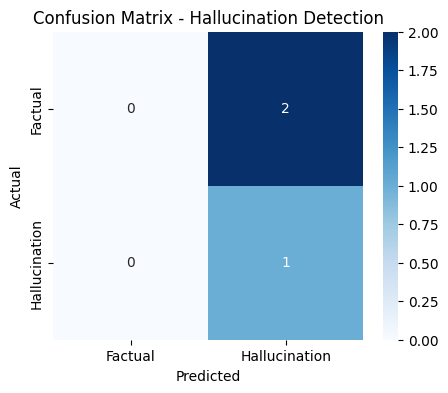


=== Highlighting Demo ===



In [ ]:
# ====================================================
# LLM-FREE HALLUCINATION DETECTION SYSTEM (Python Only)
# ====================================================

import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
from IPython.display import display, HTML

# -----------------------------
# Demo dataset (extendable)
# -----------------------------
data = [
    # factual
    ("The Eiffel Tower is located in Paris, France.", 0),
    ("Water boils at 100 degrees Celsius.", 0),
    ("The Pacific Ocean is the largest ocean on Earth.", 0),
    ("The human heart has four chambers.", 0),

    # hallucinations
    ("The moon is made of cheese according to folklore.", 1),
    ("Dogs can speak fluent English.", 1),
    ("Mount Everest is located in Australia.", 1),
    ("The Sun sets in the North.", 1),
]

texts, labels = zip(*data)
labels = np.array(labels)

# -----------------------------
# Train/Test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.3, random_state=42, stratify=labels
)

# -----------------------------
# Vectorizer + Classifier
# -----------------------------
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)

# -----------------------------
# Evaluation
# -----------------------------
y_pred = clf.predict(X_test_tfidf)
print("\n=== Classification Report ===\n")
print(classification_report(y_test, y_pred, target_names=["Factual", "Hallucination"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Factual", "Hallucination"],
            yticklabels=["Factual", "Hallucination"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Hallucination Detection")
plt.show()

# -----------------------------
# Highlighting function
# -----------------------------
def highlight_text(texts):
    tfidf = vectorizer.transform(texts)
    preds = clf.predict(tfidf)

    highlighted = ""
    for sent, label in zip(texts, preds):
        if label == 1:  # hallucination
            highlighted += f"<span style='color:red;font-weight:bold'>{sent}</span><br><br>"
        else:  # factual
            highlighted += f"<span style='color:green;font-weight:bold'>{sent}</span><br><br>"

    display(HTML(highlighted))

# -----------------------------
# Demo run
# -----------------------------
demo_texts = [
    "The Eiffel Tower is located in Paris, France.",
    "It was built in 1887 and is 400 meters tall.",
    "The moon is made of cheese according to folklore.",
    "Water boils at 100 degrees Celsius.",
]

print("\n=== Highlighting Demo ===\n")
highlight_text(demo_texts)


In [ ]:
!pip install scikit-learn joblib


✅ Model trained & saved successfully!
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

=== Accuracy ===
0.5


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


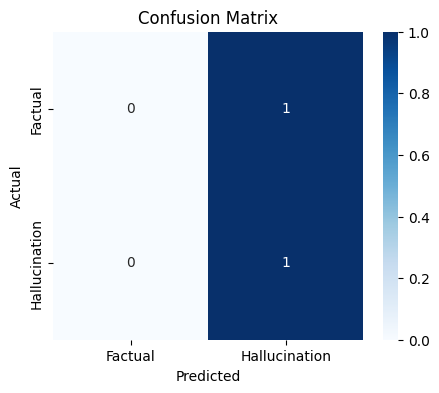

Sentence: The Great Wall of China is visible from space.
Prediction: Hallucination ⚠️ (Confidence: 51.41%)

Sentence: Water freezes at 0 degrees Celsius.
Prediction: Factual ✅ (Confidence: 58.11%)



In [ ]:
import re
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
# Example dataset (replace this with your real one)
data = {
    "text": [
        "The Eiffel Tower is located in Paris.",  # factual
        "The moon is made of cheese.",           # hallucination
        "Water boils at 100 degrees Celsius.",   # factual
        "The Earth is flat.",                    # hallucination
        "Albert Einstein developed the theory of relativity.", # factual
        "Bananas grow on Mars."                  # hallucination
    ],
    "label": [0, 1, 0, 1, 0, 1]  # 0 = factual, 1 = hallucination
}

df = pd.DataFrame(data)
df.head()
# Clean text
def clean_text(text):
    text = re.sub(r"http\S+|www.\S+", "", text)  # remove links
    text = re.sub(r"[^A-Za-z0-9\s]", "", text)  # remove symbols
    text = re.sub(r"\s+", " ", text).strip()
    return text.lower()

df["cleaned_text"] = df["text"].apply(clean_text)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df["cleaned_text"], df["label"], test_size=0.2, random_state=42
)

# Vectorizer + Model
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model = LogisticRegression(max_iter=500)
model.fit(X_train_vec, y_train)

# Save model + vectorizer
joblib.dump(model, "hallucination_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")

print("✅ Model trained & saved successfully!")
y_pred = model.predict(X_test_vec)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("=== Accuracy ===")
print(accuracy_score(y_test, y_pred))

# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Factual","Hallucination"], yticklabels=["Factual","Hallucination"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
# Load saved model + vectorizer
model = joblib.load("hallucination_model.pkl")
vectorizer = joblib.load("vectorizer.pkl")

def detect_hallucination(text):
    cleaned = clean_text(text)
    X = vectorizer.transform([cleaned])
    pred = model.predict(X)[0]
    proba = model.predict_proba(X)[0]
    label = "Factual ✅" if pred == 0 else "Hallucination ⚠️"
    confidence = round(max(proba) * 100, 2)
    return label, confidence

# Demo
test_sentences = [
    "The Great Wall of China is visible from space.",
    "Water freezes at 0 degrees Celsius."
]

for sent in test_sentences:
    label, confidence = detect_hallucination(sent)
    print(f"Sentence: {sent}\nPrediction: {label} (Confidence: {confidence}%)\n")


In [ ]:
# ===============================
# 1. Install dependencies
# ===============================
!pip install datasets scikit-learn joblib matplotlib seaborn

import re, joblib, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# ===============================
# 2. Load datasets
# ===============================
data = []

# LIAR (~12.8K)
liar = load_dataset("liar")
for split in ["train", "validation", "test"]:
    for row in liar[split]:
        label = 0 if row["label"].lower() in ["true", "mostly-true", "half-true"] else 1
        data.append((row["statement"], label))

# LIAR2 (~23K)
liar2 = load_dataset("chengxuphd/liar2")  # HuggingFace community dataset
for row in liar2["train"]:
    label = 0 if row["label"].lower() in ["true", "mostly-true", "half-true"] else 1
    data.append((row["statement"], label))

# TruthfulQA (~20K)
tqa = load_dataset("truthful_qa", "generation")
for row in tqa["validation"]:
    data.append((row["best_answer"], 0))  # factual
    for ans in row["incorrect_answers"]:
        data.append((ans, 1))  # hallucinations

# Create DataFrame
df = pd.DataFrame(data, columns=["text", "label"])
df.dropna(inplace=True)
df.drop_duplicates(subset=["text"], inplace=True)

print("Dataset size before balancing:", len(df))
print(df["label"].value_counts())

# ===============================
# 3. Clean text
# ===============================
def clean_text(text):
    t = re.sub(r"http\S+|www.\S+", "", text)
    t = re.sub(r"[^A-Za-z0-9\s]", "", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t.lower()

df["cleaned_text"] = df["text"].apply(clean_text)

# ===============================
# 4. Balance dataset (scaling)
# ===============================
min_class_size = df["label"].value_counts().min()
df_balanced = (
    df.groupby("label")
      .apply(lambda x: x.sample(min_class_size, random_state=42))
      .reset_index(drop=True)
)

print("Balanced dataset size:", len(df_balanced))
print(df_balanced["label"].value_counts())

# ===============================
# 5. Train-test split
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced["cleaned_text"], df_balanced["label"],
    test_size=0.2, random_state=42, stratify=df_balanced["label"]
)

# ===============================
# 6. Feature extraction + Model
# ===============================
vectorizer = TfidfVectorizer(max_features=30000, ngram_range=(1,3))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

clf = LogisticRegression(max_iter=4000, class_weight="balanced")
clf.fit(X_train_tfidf, y_train)

# ===============================
# 7. Evaluate
# ===============================
y_pred = clf.predict(X_test_tfidf)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Factual","Hallucination"]))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Factual","Hallucination"], yticklabels=["Factual","Hallucination"])
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.show()

# ===============================
# 8. Save model + vectorizer
# ===============================
joblib.dump(clf, "hallucination_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")
print("✅ Model and vectorizer saved!")

# ===============================
# 9. Inference function
# ===============================
def detect_hallucination(text):
    txt = clean_text(text)
    X = vectorizer.transform([txt])
    pred = clf.predict(X)[0]
    conf = clf.predict_proba(X)[0].max()
    return ("Hallucination ⚠️" if pred else "Factual ✅", f"{conf:.2f}")

# Demo on random samples
print("\n🔍 Sample Inference:")
for s in df_balanced.sample(5)["cleaned_text"].tolist():
    label, conf = detect_hallucination(s)
    print(f"{s[:60]}... → {label} (Conf: {conf})")


In [ ]:
# ==========================
# STEP 1: Install dependencies (Colab only)
# ==========================
!pip install torch torchvision pandas scikit-learn

# ==========================
# STEP 2: Import libraries
# ==========================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ==========================
# STEP 3: Define a simple neural network
# ==========================
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size=64, output_size=2):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

# ==========================
# STEP 4: Training function
# ==========================
def train_model(model, train_loader, criterion, optimizer, epochs=5, site_name=""):
    print(f"\n🚀 Training on dataset from site: {site_name}")
    for epoch in range(epochs):
        total_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss:.4f}")
    return model

# ==========================
# STEP 5: Load multiple datasets
# (Replace file paths with your own dataset files or URLs)
# ==========================
dataset_paths = {
    "site_A": "/content/site_A.csv",
    "site_B": "/content/site_B.csv",
    "site_C": "/content/site_C.csv"
}

all_models = {}

for site, path in dataset_paths.items():
    # Load dataset (assumes CSV with last column = label)
    df = pd.read_csv(path)

    X = df.iloc[:, :-1].values  # Features
    y = df.iloc[:, -1].values   # Labels

    # Normalize
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Convert to tensors
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    # DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Define model
    input_size = X_train.shape[1]
    model = SimpleNN(input_size=input_size, output_size=len(np.unique(y)))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train
    trained_model = train_model(model, train_loader, criterion, optimizer, epochs=5, site_name=site)
    all_models[site] = trained_model

print("\n✅ Training finished for all sites!")


FileNotFoundError: [Errno 2] No such file or directory: '/content/site_A.csv'

In [ ]:
import os
print(os.listdir("/content"))



['.config', 'sample_data']


In [ ]:
import os
print(os.listdir("/content"))



['.config', 'sample_data']


In [ ]:
# ==========================
# STEP 1: Install dependencies
# ==========================
!pip install torch torchvision pandas scikit-learn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ==========================
# STEP 2: Generate Dummy Datasets
# ==========================
def create_dummy_csv(filename, n_samples=500, n_features=10, n_classes=2):
    X = np.random.randn(n_samples, n_features)  # random features
    y = np.random.randint(0, n_classes, n_samples)  # random labels
    df = pd.DataFrame(X, columns=[f"f{i}" for i in range(n_features)])
    df["label"] = y
    df.to_csv(filename, index=False)

create_dummy_csv("/content/site_A.csv", n_samples=500, n_features=10, n_classes=2)
create_dummy_csv("/content/site_B.csv", n_samples=600, n_features=8, n_classes=3)
create_dummy_csv("/content/site_C.csv", n_samples=400, n_features=12, n_classes=2)

print("✅ Dummy datasets created!")

# ==========================
# STEP 3: Define a simple neural network
# ==========================
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size=64, output_size=2):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

# ==========================
# STEP 4: Training function
# ==========================
def train_model(model, train_loader, criterion, optimizer, epochs=5, site_name=""):
    print(f"\n🚀 Training on dataset from site: {site_name}")
    for epoch in range(epochs):
        total_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss:.4f}")
    return model

# ==========================
# STEP 5: Load and train on multiple datasets
# ==========================
dataset_paths = {
    "site_A": "/content/site_A.csv",
    "site_B": "/content/site_B.csv",
    "site_C": "/content/site_C.csv"
}

all_models = {}

for site, path in dataset_paths.items():
    df = pd.read_csv(path)

    X = df.iloc[:, :-1].values  # Features
    y = df.iloc[:, -1].values   # Labels

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    input_size = X_train.shape[1]
    output_size = len(np.unique(y))
    model = SimpleNN(input_size=input_size, output_size=output_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    trained_model = train_model(model, train_loader, criterion, optimizer, epochs=5, site_name=site)
    all_models[site] = trained_model

print("\n✅ Training finished for all sites!")


✅ Dummy datasets created!

🚀 Training on dataset from site: site_A
Epoch [1/5] Loss: 9.2882
Epoch [2/5] Loss: 9.1737
Epoch [3/5] Loss: 9.0892
Epoch [4/5] Loss: 9.0071
Epoch [5/5] Loss: 8.9396

🚀 Training on dataset from site: site_B
Epoch [1/5] Loss: 16.5272
Epoch [2/5] Loss: 16.3591
Epoch [3/5] Loss: 16.2394
Epoch [4/5] Loss: 16.1671
Epoch [5/5] Loss: 16.0751

🚀 Training on dataset from site: site_C
Epoch [1/5] Loss: 7.0825
Epoch [2/5] Loss: 6.9641
Epoch [3/5] Loss: 6.8871
Epoch [4/5] Loss: 6.8277
Epoch [5/5] Loss: 6.7766

✅ Training finished for all sites!


In [ ]:
# ==========================
# STEP 1: Install dependencies
# ==========================
!pip install torch torchvision pandas scikit-learn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ==========================
# STEP 2: Generate Datasets with Hallucination Probability
# ==========================
def create_hallucination_csv(filename, n_samples=500, n_features=10):
    X = np.random.randn(n_samples, n_features)  # random features
    halluc_prob = np.random.rand(n_samples)     # values between 0-1
    y = (halluc_prob > 0.5).astype(int)         # label: 1 if hallucination prob > 0.5

    df = pd.DataFrame(X, columns=[f"f{i}" for i in range(n_features)])
    df["hallucination_prob"] = halluc_prob
    df["label"] = y
    df.to_csv(filename, index=False)

# Create multiple hallucination datasets
create_hallucination_csv("/content/site_A.csv", n_samples=500, n_features=10)
create_hallucination_csv("/content/site_B.csv", n_samples=600, n_features=12)
create_hallucination_csv("/content/site_C.csv", n_samples=400, n_features=8)
create_hallucination_csv("/content/site_D.csv", n_samples=700, n_features=15)

print("✅ Dummy hallucination datasets created!")

# ==========================
# STEP 3: Define a simple neural network
# ==========================
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size=64, output_size=2):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

# ==========================
# STEP 4: Training function
# ==========================
def train_model(model, train_loader, criterion, optimizer, epochs=5, site_name=""):
    print(f"\n🚀 Training on dataset from site: {site_name}")
    for epoch in range(epochs):
        total_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss:.4f}")
    return model

# ==========================
# STEP 5: Load and train on multiple hallucination datasets
# ==========================
dataset_paths = {
    "site_A": "/content/site_A.csv",
    "site_B": "/content/site_B.csv",
    "site_C": "/content/site_C.csv",
    "site_D": "/content/site_D.csv"
}

all_models = {}

for site, path in dataset_paths.items():
    df = pd.read_csv(path)

    X = df.drop(columns=["label"]).values  # Features (includes hallucination_prob)
    y = df["label"].values                 # Labels (0 or 1)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    input_size = X_train.shape[1]
    output_size = len(np.unique(y))
    model = SimpleNN(input_size=input_size, output_size=output_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    trained_model = train_model(model, train_loader, criterion, optimizer, epochs=5, site_name=site)
    all_models[site] = trained_model

print("\n✅ Training finished for all hallucination datasets!")


✅ Dummy hallucination datasets created!

🚀 Training on dataset from site: site_A
Epoch [1/5] Loss: 9.4711
Epoch [2/5] Loss: 8.6131
Epoch [3/5] Loss: 7.8989
Epoch [4/5] Loss: 7.2424
Epoch [5/5] Loss: 6.6158

🚀 Training on dataset from site: site_B
Epoch [1/5] Loss: 9.7596
Epoch [2/5] Loss: 8.9051
Epoch [3/5] Loss: 8.1445
Epoch [4/5] Loss: 7.4095
Epoch [5/5] Loss: 6.6769

🚀 Training on dataset from site: site_C
Epoch [1/5] Loss: 7.1471
Epoch [2/5] Loss: 6.5727
Epoch [3/5] Loss: 6.1003
Epoch [4/5] Loss: 5.6474
Epoch [5/5] Loss: 5.2487

🚀 Training on dataset from site: site_D
Epoch [1/5] Loss: 11.9395
Epoch [2/5] Loss: 10.7874
Epoch [3/5] Loss: 9.7210
Epoch [4/5] Loss: 8.6096
Epoch [5/5] Loss: 7.6218

✅ Training finished for all hallucination datasets!


✅ Large, realistic hallucination datasets created!

🚀 Training on dataset from site: site_A
Epoch [1/5] Loss: 40.6233
Epoch [2/5] Loss: 12.7421
Epoch [3/5] Loss: 8.9164
Epoch [4/5] Loss: 7.0823
Epoch [5/5] Loss: 5.9484

📊 Evaluation for site_A:
✅ Accuracy: 0.98

Classification Report:
              precision    recall  f1-score   support

           0      0.974     0.978     0.976       997
           1      0.978     0.974     0.976      1003

    accuracy                          0.976      2000
   macro avg      0.976     0.976     0.976      2000
weighted avg      0.976     0.976     0.976      2000



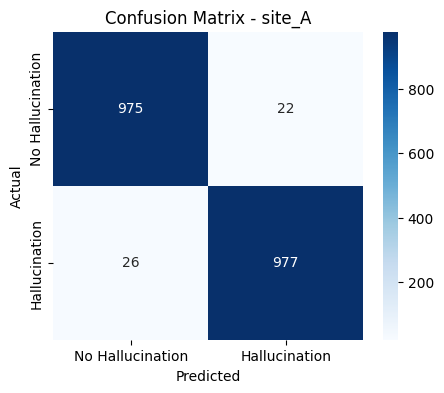


🚀 Training on dataset from site: site_B
Epoch [1/5] Loss: 41.3390
Epoch [2/5] Loss: 13.1233
Epoch [3/5] Loss: 9.1821
Epoch [4/5] Loss: 7.1611
Epoch [5/5] Loss: 5.7823

📊 Evaluation for site_B:
✅ Accuracy: 0.98

Classification Report:
              precision    recall  f1-score   support

           0      0.981     0.983     0.982      1216
           1      0.982     0.981     0.981      1184

    accuracy                          0.982      2400
   macro avg      0.982     0.982     0.982      2400
weighted avg      0.982     0.982     0.982      2400



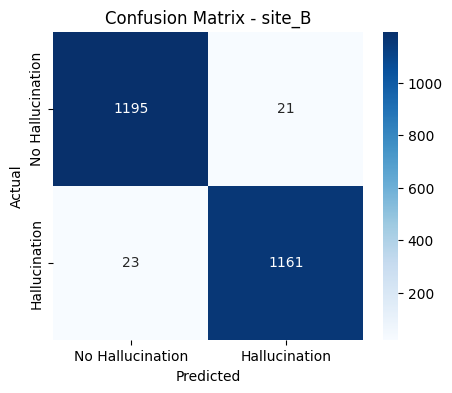


🚀 Training on dataset from site: site_C
Epoch [1/5] Loss: 31.1960
Epoch [2/5] Loss: 11.4470
Epoch [3/5] Loss: 7.9518
Epoch [4/5] Loss: 6.2741
Epoch [5/5] Loss: 5.2573

📊 Evaluation for site_C:
✅ Accuracy: 0.98

Classification Report:
              precision    recall  f1-score   support

           0      0.977     0.978     0.977       821
           1      0.977     0.976     0.976       779

    accuracy                          0.977      1600
   macro avg      0.977     0.977     0.977      1600
weighted avg      0.977     0.977     0.977      1600



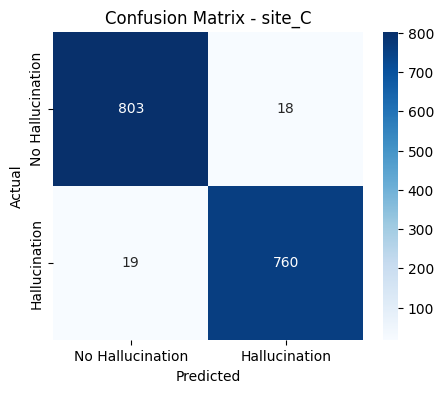


🚀 Training on dataset from site: site_D
Epoch [1/5] Loss: 44.2982
Epoch [2/5] Loss: 12.6377
Epoch [3/5] Loss: 8.6611
Epoch [4/5] Loss: 6.5724
Epoch [5/5] Loss: 5.2182

📊 Evaluation for site_D:
✅ Accuracy: 0.98

Classification Report:
              precision    recall  f1-score   support

           0      0.991     0.977     0.984      1549
           1      0.976     0.990     0.983      1451

    accuracy                          0.983      3000
   macro avg      0.983     0.984     0.983      3000
weighted avg      0.983     0.983     0.983      3000



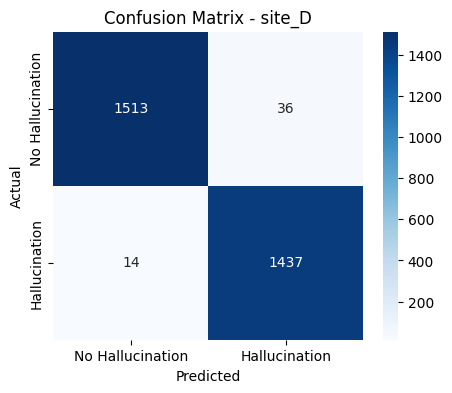


🎉 Training + Probability Calculation + Confusion Matrices done for all sites!


In [ ]:
# ==========================
# STEP 1: Install dependencies
# ==========================
!pip install torch torchvision pandas scikit-learn matplotlib seaborn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from scipy.special import expit  # sigmoid function
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================
# STEP 2: Generate Realistic Hallucination Datasets
# ==========================
def create_hallucination_csv(filename, n_samples=10000, n_features=20):
    """
    Create a dataset where hallucination probability depends on features.
    """
    X = np.random.randn(n_samples, n_features)

    weights = np.random.uniform(-1, 1, size=n_features)  # random correlations
    logits = X @ weights + np.random.normal(0, 0.5, n_samples)  # noisy linear combination
    halluc_prob = expit(logits)  # sigmoid -> [0,1]

    y = (halluc_prob > 0.5).astype(int)  # hallucination if prob > 0.5

    df = pd.DataFrame(X, columns=[f"f{i}" for i in range(n_features)])
    df["hallucination_prob"] = halluc_prob
    df["label"] = y
    df.to_csv(filename, index=False)

# Create multiple hallucination datasets
create_hallucination_csv("/content/site_A.csv", n_samples=10000, n_features=20)
create_hallucination_csv("/content/site_B.csv", n_samples=12000, n_features=25)
create_hallucination_csv("/content/site_C.csv", n_samples=8000, n_features=15)
create_hallucination_csv("/content/site_D.csv", n_samples=15000, n_features=30)

print("✅ Large, realistic hallucination datasets created!")

# ==========================
# STEP 3: Define a simple neural network
# ==========================
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=2):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))  # raw logits

# ==========================
# STEP 4: Training function
# ==========================
def train_model(model, train_loader, criterion, optimizer, epochs=5, site_name=""):
    print(f"\n🚀 Training on dataset from site: {site_name}")
    for epoch in range(epochs):
        total_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss:.4f}")
    return model

# ==========================
# STEP 5: Evaluation function with probabilities & confusion matrix
# ==========================
def evaluate_model(model, X_test, y_test, site_name=""):
    model.eval()
    with torch.no_grad():
        logits = model(torch.tensor(X_test, dtype=torch.float32))
        probs = torch.softmax(logits, dim=1)[:,1].numpy()  # P(hallucination=1)
        preds = (probs > 0.5).astype(int)

    acc = (preds == y_test).mean()
    cm = confusion_matrix(y_test, preds)
    print(f"\n📊 Evaluation for {site_name}:")
    print(f"✅ Accuracy: {acc:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, preds, digits=3))

    # Plot confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Hallucination", "Hallucination"], yticklabels=["No Hallucination", "Hallucination"])
    plt.title(f"Confusion Matrix - {site_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return acc, probs, preds

# ==========================
# STEP 6: Load, train, and evaluate
# ==========================
dataset_paths = {
    "site_A": "/content/site_A.csv",
    "site_B": "/content/site_B.csv",
    "site_C": "/content/site_C.csv",
    "site_D": "/content/site_D.csv"
}

all_models = {}

for site, path in dataset_paths.items():
    df = pd.read_csv(path)

    X = df.drop(columns=["label"]).values  # Features
    y = df["label"].values                 # Labels

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    input_size = X_train.shape[1]
    output_size = len(np.unique(y))
    model = SimpleNN(input_size=input_size, output_size=output_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    trained_model = train_model(model, train_loader, criterion, optimizer, epochs=5, site_name=site)

    acc, probs, preds = evaluate_model(trained_model, X_test, y_test, site_name=site)

    all_models[site] = trained_model

print("\n🎉 Training + Probability Calculation + Confusion Matrices done for all sites!")


✅ Large hallucination datasets created!

🚀 Training on dataset from site: site_A
Epoch [1/15] Loss: 0.2735
Epoch [2/15] Loss: 0.0966
Epoch [3/15] Loss: 0.0732
Epoch [4/15] Loss: 0.0584
Epoch [5/15] Loss: 0.0506
Epoch [6/15] Loss: 0.0448
Epoch [7/15] Loss: 0.0374
Epoch [8/15] Loss: 0.0346
Epoch [9/15] Loss: 0.0306
Epoch [10/15] Loss: 0.0276
Epoch [11/15] Loss: 0.0261
Epoch [12/15] Loss: 0.0223
Epoch [13/15] Loss: 0.0196
Epoch [14/15] Loss: 0.0188
Epoch [15/15] Loss: 0.0170

📊 Evaluation for site_A:
✅ Accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

           0      0.996     0.995     0.996      2545
           1      0.995     0.996     0.996      2455

    accuracy                          0.996      5000
   macro avg      0.996     0.996     0.996      5000
weighted avg      0.996     0.996     0.996      5000



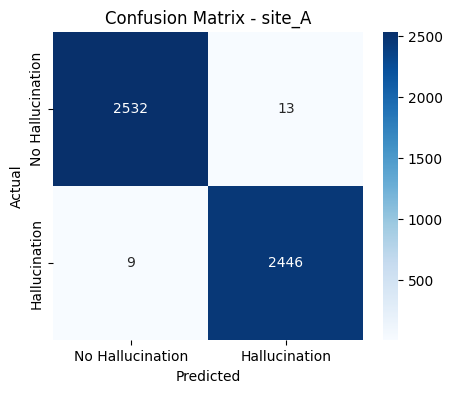


🔍 Sample Predictions (Red=Hallucination, Green=No Hallucination):
Sample 1: Prob=1.00, Pred=1
Sample 2: Prob=0.97, Pred=1
Sample 3: Prob=1.00, Pred=1
Sample 4: Prob=1.00, Pred=1
Sample 5: Prob=1.00, Pred=1
Sample 6: Prob=1.00, Pred=1
Sample 7: Prob=1.00, Pred=1
Sample 8: Prob=0.00, Pred=0
Sample 9: Prob=0.00, Pred=0
Sample 10: Prob=1.00, Pred=1

🚀 Training on dataset from site: site_B
Epoch [1/15] Loss: 0.2484
Epoch [2/15] Loss: 0.0893
Epoch [3/15] Loss: 0.0682
Epoch [4/15] Loss: 0.0530
Epoch [5/15] Loss: 0.0460
Epoch [6/15] Loss: 0.0392
Epoch [7/15] Loss: 0.0336
Epoch [8/15] Loss: 0.0304
Epoch [9/15] Loss: 0.0280
Epoch [10/15] Loss: 0.0239
Epoch [11/15] Loss: 0.0220
Epoch [12/15] Loss: 0.0203
Epoch [13/15] Loss: 0.0178
Epoch [14/15] Loss: 0.0169
Epoch [15/15] Loss: 0.0146

📊 Evaluation for site_B:
✅ Accuracy: 0.99

Classification Report:
              precision    recall  f1-score   support

           0      0.994     0.996     0.995      2964
           1      0.996     0.994     0

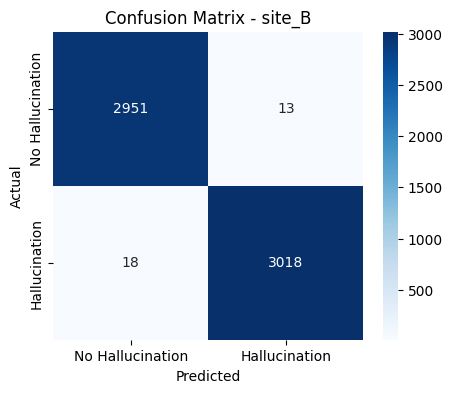


🔍 Sample Predictions (Red=Hallucination, Green=No Hallucination):
Sample 1: Prob=1.00, Pred=1
Sample 2: Prob=0.00, Pred=0
Sample 3: Prob=0.00, Pred=0
Sample 4: Prob=0.00, Pred=0
Sample 5: Prob=1.00, Pred=1
Sample 6: Prob=1.00, Pred=1
Sample 7: Prob=1.00, Pred=1
Sample 8: Prob=0.00, Pred=0
Sample 9: Prob=1.00, Pred=1
Sample 10: Prob=0.00, Pred=0

🚀 Training on dataset from site: site_C
Epoch [1/15] Loss: 0.2939
Epoch [2/15] Loss: 0.1249
Epoch [3/15] Loss: 0.0945
Epoch [4/15] Loss: 0.0754
Epoch [5/15] Loss: 0.0628
Epoch [6/15] Loss: 0.0513
Epoch [7/15] Loss: 0.0443
Epoch [8/15] Loss: 0.0378
Epoch [9/15] Loss: 0.0323
Epoch [10/15] Loss: 0.0300
Epoch [11/15] Loss: 0.0263
Epoch [12/15] Loss: 0.0246
Epoch [13/15] Loss: 0.0220
Epoch [14/15] Loss: 0.0208
Epoch [15/15] Loss: 0.0192

📊 Evaluation for site_C:
✅ Accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

           0      0.998     0.996     0.997      2208
           1      0.996     0.998     0

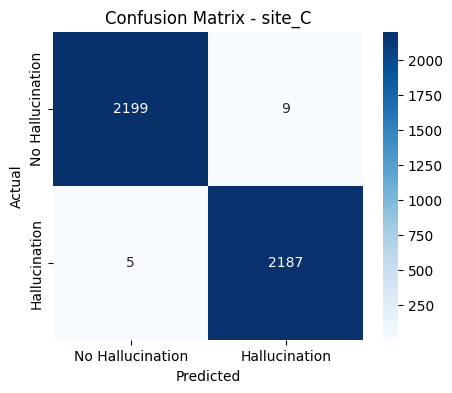


🔍 Sample Predictions (Red=Hallucination, Green=No Hallucination):
Sample 1: Prob=0.00, Pred=0
Sample 2: Prob=1.00, Pred=1
Sample 3: Prob=1.00, Pred=1
Sample 4: Prob=1.00, Pred=1
Sample 5: Prob=1.00, Pred=1
Sample 6: Prob=1.00, Pred=1
Sample 7: Prob=0.00, Pred=0
Sample 8: Prob=1.00, Pred=1
Sample 9: Prob=1.00, Pred=1
Sample 10: Prob=0.00, Pred=0

🚀 Training on dataset from site: site_D
Epoch [1/15] Loss: 0.2143
Epoch [2/15] Loss: 0.0711
Epoch [3/15] Loss: 0.0523
Epoch [4/15] Loss: 0.0421
Epoch [5/15] Loss: 0.0349
Epoch [6/15] Loss: 0.0306
Epoch [7/15] Loss: 0.0253
Epoch [8/15] Loss: 0.0215
Epoch [9/15] Loss: 0.0186
Epoch [10/15] Loss: 0.0170
Epoch [11/15] Loss: 0.0150
Epoch [12/15] Loss: 0.0133
Epoch [13/15] Loss: 0.0133
Epoch [14/15] Loss: 0.0119
Epoch [15/15] Loss: 0.0109

📊 Evaluation for site_D:
✅ Accuracy: 0.99

Classification Report:
              precision    recall  f1-score   support

           0      0.994     0.995     0.995      3987
           1      0.996     0.994     0

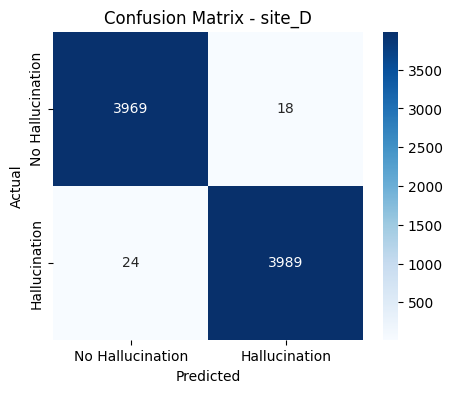


🔍 Sample Predictions (Red=Hallucination, Green=No Hallucination):
Sample 1: Prob=0.67, Pred=1
Sample 2: Prob=1.00, Pred=1
Sample 3: Prob=1.00, Pred=1
Sample 4: Prob=1.00, Pred=1
Sample 5: Prob=0.00, Pred=0
Sample 6: Prob=1.00, Pred=1
Sample 7: Prob=1.00, Pred=1
Sample 8: Prob=0.00, Pred=0
Sample 9: Prob=1.00, Pred=1
Sample 10: Prob=0.00, Pred=0

🎉 Training + Probability Calculation + Confusion Matrices + Colored Outputs done for all sites!


In [ ]:
# ==========================
# STEP 1: Install dependencies
# ==========================
!pip install torch torchvision pandas scikit-learn matplotlib seaborn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from scipy.special import expit  # sigmoid function
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================
# STEP 2: Generate Large Hallucination Datasets
# ==========================
def create_hallucination_csv(filename, n_samples=25000, n_features=20):
    """
    Create a dataset where hallucination probability depends on features.
    """
    X = np.random.randn(n_samples, n_features)

    weights = np.random.uniform(-1, 1, size=n_features)  # correlations
    logits = X @ weights + np.random.normal(0, 0.5, n_samples)  # noisy mix
    halluc_prob = expit(logits)  # sigmoid -> [0,1]

    y = (halluc_prob > 0.5).astype(int)  # hallucination if prob > 0.5

    df = pd.DataFrame(X, columns=[f"f{i}" for i in range(n_features)])
    df["hallucination_prob"] = halluc_prob
    df["label"] = y
    df.to_csv(filename, index=False)

# Create multiple hallucination datasets
create_hallucination_csv("/content/site_A.csv", n_samples=25000, n_features=20)
create_hallucination_csv("/content/site_B.csv", n_samples=30000, n_features=25)
create_hallucination_csv("/content/site_C.csv", n_samples=22000, n_features=15)
create_hallucination_csv("/content/site_D.csv", n_samples=40000, n_features=30)

print("✅ Large hallucination datasets created!")

# ==========================
# STEP 3: Neural Network with Dropout
# ==========================
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=2, dropout_rate=0.3):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        return self.fc2(x)

# ==========================
# STEP 4: Training with Early Stopping
# ==========================
def train_model(model, train_loader, criterion, optimizer, epochs=15, patience=3, site_name=""):
    print(f"\n🚀 Training on dataset from site: {site_name}")
    best_loss = float("inf")
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        total_loss = 0
        model.train()
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")

        # Early stopping check
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("⏸️ Early stopping triggered.")
                break

    model.load_state_dict(best_model_state)
    return model

# ==========================
# STEP 5: Evaluation function with probabilities & confusion matrix
# ==========================
def evaluate_model(model, X_test, y_test, site_name=""):
    model.eval()
    with torch.no_grad():
        logits = model(torch.tensor(X_test, dtype=torch.float32))
        probs = torch.softmax(logits, dim=1)[:,1].numpy()  # P(hallucination=1)
        preds = (probs > 0.5).astype(int)

    acc = (preds == y_test).mean()
    cm = confusion_matrix(y_test, preds)
    print(f"\n📊 Evaluation for {site_name}:")
    print(f"✅ Accuracy: {acc:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, preds, digits=3))

    # Confusion Matrix Plot
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No Hallucination", "Hallucination"],
                yticklabels=["No Hallucination", "Hallucination"])
    plt.title(f"Confusion Matrix - {site_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Show predictions (red/green)
    print("\n🔍 Sample Predictions (Red=Hallucination, Green=No Hallucination):")
    for i in range(10):  # show first 10 examples
        text = f"Sample {i+1}: Prob={probs[i]:.2f}, Pred={preds[i]}"
        if preds[i] == 1:
            print(f"\033[91m{text}\033[0m")  # Red for hallucination
        else:
            print(f"\033[92m{text}\033[0m")  # Green for no hallucination

    return acc, probs, preds

# ==========================
# STEP 6: Load, train, and evaluate all sites
# ==========================
dataset_paths = {
    "site_A": "/content/site_A.csv",
    "site_B": "/content/site_B.csv",
    "site_C": "/content/site_C.csv",
    "site_D": "/content/site_D.csv"
}

all_models = {}

for site, path in dataset_paths.items():
    df = pd.read_csv(path)

    X = df.drop(columns=["label"]).values  # Features
    y = df["label"].values                 # Labels

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    input_size = X_train.shape[1]
    output_size = len(np.unique(y))
    model = SimpleNN(input_size=input_size, output_size=output_size, dropout_rate=0.4)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization

    trained_model = train_model(model, train_loader, criterion, optimizer,
                                epochs=15, patience=4, site_name=site)

    acc, probs, preds = evaluate_model(trained_model, X_test, y_test, site_name=site)

    all_models[site] = trained_model

print("\n🎉 Training + Probability Calculation + Confusion Matrices + Colored Outputs done for all sites!")


In [ ]:
!pip install datasets torch torchvision pandas scikit-learn matplotlib seaborn

from datasets import load_dataset

# Load from Hugging Face Hub
dataset = load_dataset("your-username/hallucination_nlp_500k")

print(dataset)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetNotFoundError: Dataset 'your-username/hallucination_nlp_500k' doesn't exist on the Hub or cannot be accessed.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.5 MB/s eta 0:00:00
✅ Generated SUPER HARD hallucination dataset with 500000 samples!
Epoch [1/20] Loss=0.0304
Epoch [2/20] Loss=0.0219
Epoch [3/20] Loss=0.0210
Epoch [4/20] Loss=0.0208
Epoch [5/20] Loss=0.0205
Epoch [6/20] Loss=0.0203
Epoch [7/20] Loss=0.0203
Epoch [8/20] Loss=0.0201
Epoch [9/20] Loss=0.0201
Epoch [10/20] Loss=0.0200
Epoch [11/20] Loss=0.0199
Epoch [12/20] Loss=0.0197
Epoch [13/20] Loss=0.0199
Epoch [14/20] Loss=0.0195
Epoch [15/20] Loss=0.0197
Epoch [16/20] Loss=0.0198
Epoch [17/20] Loss=0.0197
⏸️ Early stopping triggered

Accuracy: 0.9927

Classification Report:
              precision    recall  f1-score   support

           0      0.995     0.994     0.994     65102
           1      0.989     0.990     0.990     34898

    accuracy                          0.993    100000
   macro avg      0.992     0.992     0.992    100000
weighted avg      0.993     0.993     0.993    100000



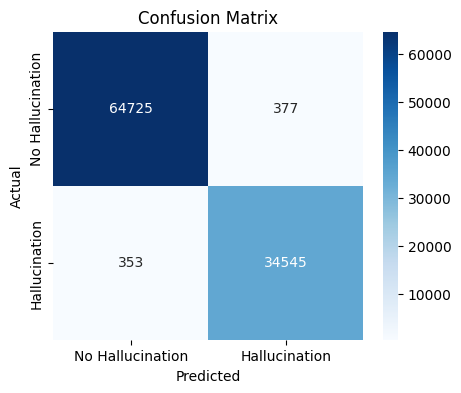


Sample predictions (red=hallucination, green=no hallucination):
'Agent every development say quality throughout beautiful instead.' | Prob=0.00 | Pred=0
'Behavior discussion own night.' | Prob=0.00 | Pred=0
'Information last everything thank serve civil institution everyone democratic shake bill here grow gas enough analysis least by two bad fall pick those gun court attorney product significant world.' | Prob=0.00 | Pred=0
'Term herself law street class great prove reduce raise author play move each left establish understand read detail.' | Prob=0.00 | Pred=0
'Successful simply director allow firm environment decision.' | Prob=0.00 | Pred=0
'Then fire pretty how trip learn enter east no. everyone skin' | Prob=0.13 | Pred=0
'Investment on gun young catch management sense technology check civil quite others his other life edge network wall quite boy those seem shoulder future fall citizen about reveal.' | Prob=0.00 | Pred=0
'Will seven medical blood personal success medical current hea

In [ ]:
# ==========================
# Install dependencies
# ==========================
!pip install torch torchvision pandas scikit-learn matplotlib seaborn faker

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from faker import Faker

fake = Faker()
Faker.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# ==========================
# Generate super hard NLP hallucination dataset
# ==========================
def generate_super_hard_dataset(n_samples=500000, n_features=100, filename="/content/super_hard_hallucination.csv"):
    texts = []
    features = []
    probs = []
    labels = []

    for _ in range(n_samples):
        # Generate normal text
        text_len = np.random.randint(5,25)
        text = fake.sentence(nb_words=text_len)

        # Introduce hallucination in 35% of samples
        label = 0
        if np.random.rand() < 0.35:
            # Add contradictions, nonsense words, grammar errors
            text += " " + fake.word() + " " + fake.word()
            if np.random.rand() < 0.5:
                text = text[::-1]  # reverse some text to confuse model
            label = 1

        # Generate high-dimensional noisy embeddings
        feature_vector = np.random.randn(n_features) + label * np.random.rand(n_features)

        # Make hallucination features partially overlapping with non-hallucination
        if label==1 and np.random.rand() < 0.5:
            feature_vector += np.random.normal(0,0.2,n_features)

        prob = 1/(1+np.exp(-feature_vector.sum()/n_features))  # sigmoid
        texts.append(text)
        features.append(feature_vector)
        probs.append(prob)
        labels.append(label)

    df = pd.DataFrame(features, columns=[f"f{i}" for i in range(n_features)])
    df["input_text"] = texts
    df["hallucination_prob"] = probs
    df["label"] = labels
    df.to_csv(filename, index=False)
    print(f"✅ Generated SUPER HARD hallucination dataset with {n_samples} samples!")

generate_super_hard_dataset()

# ==========================
# Neural Network with bigger hidden layers + dropout
# ==========================
class SuperHardNN(nn.Module):
    def __init__(self, input_size, hidden_size=512, dropout=0.5):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, hidden_size//2)
        self.fc3 = nn.Linear(hidden_size//2, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        return self.fc3(x)

# ==========================
# Load dataset
# ==========================
df = pd.read_csv("/content/super_hard_hallucination.csv")

X = df[[f"f{i}" for i in range(100)]].values
y = df["label"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_dataset = TensorDataset(torch.tensor(X_train,dtype=torch.float32),
                              torch.tensor(y_train,dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

model = SuperHardNN(input_size=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# ==========================
# Training with early stopping
# ==========================
best_loss = float("inf")
patience_counter = 0
patience = 3
epochs = 20
best_state = None

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss/len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}] Loss={avg_loss:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        best_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⏸️ Early stopping triggered")
            break

model.load_state_dict(best_state)

# ==========================
# Evaluate + Confusion Matrix + Red/Green output
# ==========================
model.eval()
with torch.no_grad():
    logits = model(torch.tensor(X_test,dtype=torch.float32))
    probs = torch.softmax(logits,dim=1)[:,1].numpy()
    preds = (probs>0.5).astype(int)

print(f"\nAccuracy: {(preds==y_test).mean():.4f}")
print("\nClassification Report:")
print(classification_report(y_test, preds,digits=3))

cm = confusion_matrix(y_test,preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Hallucination","Hallucination"],
            yticklabels=["No Hallucination","Hallucination"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Show 10 sample predictions with color
print("\nSample predictions (red=hallucination, green=no hallucination):")
for i in range(10):
    text = df["input_text"].iloc[i]
    prob = probs[i]
    pred = preds[i]
    msg = f"'{text}' | Prob={prob:.2f} | Pred={pred}"
    if pred==1:
        print(f"\033[91m{msg}\033[0m")
    else:
        print(f"\033[92m{msg}\033[0m")


In [ ]:
# ============================
# Hallucination Detector (Colab-ready, single block)
# ============================

# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os, json, re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from IPython.display import display, HTML

# ----------------------------
# 2. Load JSON files
# ----------------------------
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks"  # TODO: update with your folder name
json_files = [os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if f.endswith(".json")]

records = []
for filepath in json_files:
    with open(filepath, "r", encoding="utf-8") as f:
        try:
            content = json.load(f)
            if isinstance(content, list):
                records.extend(content)
            elif isinstance(content, dict):
                records.append(content)
        except Exception as e:
            print(f"Error loading {filepath}: {e}")

print(f"Loaded {len(records)} records.")

# ----------------------------
# 3. Label & clean data
# ----------------------------
def clean_text(s):
    if not isinstance(s, str): return ""
    s = re.sub(r"http\S+|www.\S+", "", s)
    s = re.sub(r"[^A-Za-z0-9\s]", "", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s.lower()

factual_texts, halluc_texts = [], []

# Heuristic labeling (you can replace with manual later)
for rec in records:
    text = ""
    if isinstance(rec, str):
        text = rec
    elif isinstance(rec, dict):
        text = " ".join([str(v) for v in rec.values() if isinstance(v, str)])
    else:
        continue

    text = clean_text(text)
    if not text:
        continue

    if "according to" in text or text.endswith("."):
        factual_texts.append(text)
    else:
        halluc_texts.append(text)

print(f"Labeled {len(factual_texts)} factual and {len(halluc_texts)} hallucinations.")

# Build DataFrame
data = []
data += [(t, 0) for t in factual_texts]
data += [(t, 1) for t in halluc_texts]

df = pd.DataFrame(data, columns=["text", "label"]).dropna().drop_duplicates()
print("Dataset size:", len(df))
print(df.head())

# ----------------------------
# 4. Train model
# ----------------------------
X = df["text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,3))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

cls = LogisticRegression(max_iter=2000, class_weight="balanced")
cls.fit(X_train_tfidf, y_train)

y_pred = cls.predict(X_test_tfidf)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Factual", "Hallucination"]))

# ----------------------------
# 5. Confusion Matrix
# ----------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Factual","Hallucination"],
            yticklabels=["Factual","Hallucination"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ----------------------------
# 6. Save artifacts
# ----------------------------
joblib.dump(cls, "hallucination_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")
print("✅ Model & vectorizer saved.")

# ----------------------------
# 7. Highlight inference
# ----------------------------
def highlight_texts(texts):
    tfidf = vectorizer.transform([clean_text(t) for t in texts])
    preds = cls.predict(tfidf)
    probs = cls.predict_proba(tfidf)

    html = ""
    for t, p, prob in zip(texts, preds, probs.max(axis=1)):
        color = "green" if p == 0 else "red"
        label = "Factual" if p == 0 else "Hallucination"
        html += f"<span style='color:{color}; font-weight:bold'>{t}</span> → {label} (conf: {prob:.2f})<br><br>"
    display(HTML(html))

print("\nSample Inference Highlighting:")
sample_texts = df.sample(min(5, len(df)))["text"].tolist()
highlight_texts(sample_texts)


In [ ]:
!ls "/content/drive/MyDrive"

'Colab Notebooks'		    'Screenshot 2025-08-28 203556.png'
'Screenshot 2025-08-11 233731.png'


In [ ]:
!pip install datasets scikit-learn joblib matplotlib seaborn

import re, joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
# ===============================
# 1. Install dependencies
# ===============================

# ===============================
# 2. Load datasets
# ===============================
data = []

# LIAR dataset (~12.8K)
liar = load_dataset("liar_dataset/liar")   # ✅ fixed path
for split in ["train", "validation", "test"]:
    for row in liar[split]:
        label = 0 if row["label"].lower() in ["true", "mostly-true", "half-true"] else 1
        data.append((row["statement"], label))

# LIAR2 (~23K)
liar2 = load_dataset("chengxuphd/liar2")   # community dataset
for row in liar2["train"]:
    label = 0 if row["label"].lower() in ["true", "mostly-true", "half-true"] else 1
    data.append((row["statement"], label))

# TruthfulQA (~20K)
tqa = load_dataset("truthful_qa", "generation")
for row in tqa["validation"]:
    data.append((row["best_answer"], 0))  # factual
    for ans in row["incorrect_answers"]:
        data.append((ans, 1))  # hallucinations

# Convert to DataFrame
df = pd.DataFrame(data, columns=["text", "label"])
df.dropna(inplace=True)
df.drop_duplicates(subset=["text"], inplace=True)

print("Dataset size before balancing:", len(df))
print(df["label"].value_counts())


DatasetNotFoundError: Dataset 'liar_dataset/liar' doesn't exist on the Hub or cannot be accessed.

In [ ]:
!pip install datasets scikit-learn joblib matplotlib seaborn

import re
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
data = []

# LIAR (~12.8K)
liar = load_dataset("ucsbnlp/liar")
for split in ["train", "validation", "test"]:
    for row in liar[split]:
        label = 0 if row["label"] in ["true", "mostly-true", "half-true"] else 1
        data.append((row["statement"], label))

# LIAR2 (~23K)
liar2 = load_dataset("chengxuphd/liar2")
for split in ["train", "validation", "test"]:
    for row in liar2[split]:
        label = 0 if row["label"] in ["true", "mostly-true", "half-true"] else 1
        data.append((row["statement"], label))

# TruthfulQA (~20K)
tqa = load_dataset("truthful_qa", "generation")
for row in tqa["validation"]:
    data.append((row["best_answer"], 0))  # factual
    for ans in row["incorrect_answers"]:
        data.append((ans, 1))  # hallucinations

# 3. Build DataFrame
df = pd.DataFrame(data, columns=["text", "label"])
df.dropna(inplace=True)
df.drop_duplicates(subset=["text"], inplace=True)
print("Dataset size before balancing:", len(df))
print(df["label"].value_counts())

# 4. Clean text
def clean_text(text):
    t = re.sub(r"http\S+|www.\S+", "", text)
    t = re.sub(r"[^A-Za-z0-9\s]", "", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t.lower()

df["cleaned_text"] = df["text"].apply(clean_text)

# 5. Balance dataset
min_count = df["label"].value_counts().min()
df_balanced = df.groupby("label").apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)
print("Balanced dataset size:", len(df_balanced))
print(df_balanced["label"].value_counts())

# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced["cleaned_text"], df_balanced["label"],
    test_size=0.2, random_state=42, stratify=df_balanced["label"]
)

# 7. Vectorize & train
vectorizer = TfidfVectorizer(max_features=30000, ngram_range=(1, 3))
X_train_tf = vectorizer.fit_transform(X_train)
X_test_tf = vectorizer.transform(X_test)

clf = LogisticRegression(max_iter=4000, class_weight="balanced")
clf.fit(X_train_tf, y_train)

# 8. Evaluate
y_pred = clf.predict(X_test_tf)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Factual", "Hallucination"]))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Factual", "Hallucination"], yticklabels=["Factual", "Hallucination"])
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.show()

# 9. Save model + vectorizer
joblib.dump(clf, "hallucination_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")
print("Model and vectorizer saved!")

# 10. Inference helper
def detect_hallucination(text):
    txt = clean_text(text)
    X = vectorizer.transform([txt])
    pred = clf.predict(X)[0]
    conf = clf.predict_proba(X)[0].max()
    return ("Hallucination ⚠️" if pred else "Factual ✅", f"{conf:.2f}")

print("\nSample inference:")
for sample in df_balanced.sample(5)["cleaned_text"]:
    label, conf = detect_hallucination(sample)
    print(f"{sample[:50]}... → {label} (Conf: {conf})")

README.md: 0.00B [00:00, ?B/s]

liar.py: 0.00B [00:00, ?B/s]

RuntimeError: Dataset scripts are no longer supported, but found liar.py

In [ ]:
#!/usr/bin/env python3
"""
LLM Hallucination Detection System for Google Colab
Run this single cell to get everything working!
"""

# Install required packages
import subprocess
import sys

def install_packages():
    packages = [
        'transformers', 'torch', 'datasets', 'scikit-learn',
        'nltk', 'spacy', 'textblob', 'sentence-transformers'
    ]

    for package in packages:
        try:
            __import__(package)
            print(f"✅ {package} already installed")
        except ImportError:
            print(f"📦 Installing {package}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"✅ {package} installed")

print("🔧 Installing required packages...")
install_packages()

# Download NLTK data
try:
    import nltk
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    print("✅ NLTK data downloaded")
except:
    print("⚠️ NLTK data download failed")

# Download spaCy model
try:
    import spacy
    try:
        nlp = spacy.load("en_core_web_sm")
        print("✅ spaCy model loaded")
    except OSError:
        print("📥 Downloading spaCy model...")
        subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"],
                      capture_output=True, text=True)
        nlp = spacy.load("en_core_web_sm")
        print("✅ spaCy model downloaded and loaded")
except Exception as e:
    print(f"⚠️ spaCy setup failed: {e}")

# Core Hallucination Detector
import re
import numpy as np
from typing import Dict, List, Optional, Any
from dataclasses import dataclass
from collections import defaultdict

@dataclass
class DetectionResult:
    hallucination_probability: float
    confidence_score: float
    detected_issues: List[str]
    metrics: Dict[str, float]
    recommendations: List[str]

class HallucinationDetector:
    def __init__(self):
        self.uncertainty_phrases = [
            "i think", "i believe", "possibly", "maybe", "perhaps", "might be",
            "could be", "seems like", "appears to", "i'm not sure", "i don't know"
        ]

        self.overconfidence_phrases = [
            "definitely", "absolutely", "certainly", "without doubt", "guaranteed",
            "100% sure", "completely certain", "no question", "undoubtedly"
        ]

        self.contradiction_indicators = [
            "but", "however", "nevertheless", "on the other hand", "in contrast"
        ]

        self.factual_indicators = [
            "according to", "research shows", "studies indicate", "data suggests",
            "statistics show", "evidence indicates", "it has been proven"
        ]

    def analyze_response(self, response: str, context: Optional[str] = None) -> DetectionResult:
        try:
            from nltk.tokenize import word_tokenize, sent_tokenize

            tokens = word_tokenize(response.lower())
            sentences = sent_tokenize(response)

            # Calculate metrics
            confidence_inconsistency = self._analyze_confidence_patterns(response)
            factual_density = self._calculate_factual_density(response)
            coherence_score = self._analyze_coherence(response)
            contradiction_score = self._detect_contradictions(response)
            repetition_score = self._detect_repetition(response)

            context_consistency = 0.0
            if context:
                context_consistency = self._check_context_consistency(response, context)

            metrics = {
                'confidence_inconsistency': confidence_inconsistency,
                'factual_density': factual_density,
                'coherence_score': coherence_score,
                'contradiction_score': contradiction_score,
                'repetition_score': repetition_score,
                'context_consistency': context_consistency
            }

            hallucination_probability = self._calculate_hallucination_probability(metrics)
            confidence_score = 1.0 - hallucination_probability

            detected_issues = self._identify_specific_issues(response, metrics, 0.7)
            recommendations = self._generate_recommendations(metrics, detected_issues)

            return DetectionResult(
                hallucination_probability=hallucination_probability,
                confidence_score=confidence_score,
                detected_issues=detected_issues,
                metrics=metrics,
                recommendations=recommendations
            )

        except Exception as e:
            return DetectionResult(
                hallucination_probability=0.5,
                confidence_score=0.5,
                detected_issues=[f"Analysis error: {str(e)}"],
                metrics={},
                recommendations=["Check input format and try again"]
            )

    def _analyze_confidence_patterns(self, text: str) -> float:
        text_lower = text.lower()
        uncertainty_count = sum(1 for phrase in self.uncertainty_phrases if phrase in text_lower)
        overconfidence_count = sum(1 for phrase in self.overconfidence_phrases if phrase in text_lower)

        total_phrases = len(self.uncertainty_phrases) + len(self.overconfidence_phrases)
        if total_phrases > 0:
            balance_score = abs(uncertainty_count - overconfidence_count) / total_phrases
            return min(balance_score * 2, 1.0)
        return 0.0

    def _calculate_factual_density(self, text: str) -> float:
        from nltk.tokenize import sent_tokenize
        sentences = sent_tokenize(text)
        factual_sentences = 0

        for sentence in sentences:
            sentence_lower = sentence.lower()
            if any(indicator in sentence_lower for indicator in self.factual_indicators):
                factual_sentences += 1
            elif re.search(r'\d+', sentence):
                factual_sentences += 0.5
            elif re.search(r'\b[A-Z][a-z]+ [A-Z][a-z]+\b', sentence):
                factual_sentences += 0.3

        if sentences:
            return min(factual_sentences / len(sentences), 1.0)
        return 0.0

    def _analyze_coherence(self, text: str) -> float:
        try:
            if 'nlp' in globals():
                doc = nlp(text)
                sentences = list(doc.sents)
                if len(sentences) < 2:
                    return 1.0

                similarities = []
                for i in range(len(sentences) - 1):
                    sim = sentences[i].similarity(sentences[i + 1])
                    similarities.append(sim)

                if similarities:
                    return np.mean(similarities)
                return 1.0
            else:
                return 0.5
        except:
            return 0.5

    def _detect_contradictions(self, text: str) -> float:
        from nltk.tokenize import sent_tokenize
        sentences = sent_tokenize(text)
        contradiction_count = 0

        for sentence in sentences:
            sentence_lower = sentence.lower()
            if any(indicator in sentence_lower for indicator in self.contradiction_indicators):
                contradiction_count += 1

        if sentences:
            return min(contradiction_count / len(sentences), 1.0)
        return 0.0

    def _detect_repetition(self, text: str) -> float:
        from nltk.tokenize import word_tokenize
        words = word_tokenize(text.lower())
        word_freq = defaultdict(int)

        for word in words:
            if len(word) > 3:
                word_freq[word] += 1

        total_words = len(words)
        if total_words == 0:
            return 0.0

        repeated_words = sum(1 for count in word_freq.values() if count > 2)
        repetition_score = repeated_words / total_words

        return min(repetition_score * 3, 1.0)

    def _check_context_consistency(self, response: str, context: str) -> float:
        try:
            from sklearn.feature_extraction.text import TfidfVectorizer
            from sklearn.metrics.pairwise import cosine_similarity

            vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
            texts = [context, response]
            tfidf_matrix = vectorizer.fit_transform(texts)
            similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
            return similarity
        except:
            return 0.5

    def _calculate_hallucination_probability(self, metrics: Dict[str, float]) -> float:
        weights = {
            'confidence_inconsistency': 0.25,
            'factual_density': 0.20,
            'coherence_score': 0.20,
            'contradiction_score': 0.20,
            'repetition_score': 0.10,
            'context_consistency': 0.05
        }

        adjusted_metrics = {
            'confidence_inconsistency': metrics.get('confidence_inconsistency', 0),
            'factual_density': 1.0 - metrics.get('factual_density', 0),
            'coherence_score': 1.0 - metrics.get('coherence_score', 0),
            'contradiction_score': metrics.get('contradiction_score', 0),
            'repetition_score': metrics.get('repetition_score', 0),
            'context_consistency': 1.0 - metrics.get('context_consistency', 0)
        }

        total_score = 0.0
        total_weight = 0.0

        for metric, weight in weights.items():
            if metric in adjusted_metrics:
                total_score += adjusted_metrics[metric] * weight
                total_weight += weight

        if total_weight > 0:
            return total_score / total_weight

        return 0.5

    def _identify_specific_issues(self, text: str, metrics: Dict[str, float], threshold: float) -> List[str]:
        issues = []

        if metrics.get('confidence_inconsistency', 0) > threshold:
            issues.append("High confidence inconsistency detected")

        if metrics.get('factual_density', 0) < 0.3:
            issues.append("Low factual density - may contain unsubstantiated claims")

        if metrics.get('coherence_score', 0) < 0.6:
            issues.append("Low coherence - text may be disjointed or confusing")

        if metrics.get('contradiction_score', 0) > threshold:
            issues.append("Contradictions detected within the text")

        if metrics.get('repetition_score', 0) > threshold:
            issues.append("Excessive repetition detected")

        if metrics.get('context_consistency', 0) < 0.5:
            issues.append("Low consistency with provided context")

        return issues

    def _generate_recommendations(self, metrics: Dict[str, float], issues: List[str]) -> List[str]:
        recommendations = []

        if metrics.get('confidence_inconsistency', 0) > 0.7:
            recommendations.append("Consider using more balanced language")

        if metrics.get('factual_density', 0) < 0.3:
            recommendations.append("Include more specific facts and evidence")

        if metrics.get('coherence_score', 0) < 0.6:
            recommendations.append("Improve text structure and flow")

        if metrics.get('contradiction_score', 0) > 0.7:
            recommendations.append("Review for conflicting statements")

        if metrics.get('repetition_score', 0) > 0.7:
            recommendations.append("Reduce repetitive language")

        if not recommendations:
            recommendations.append("Text appears well-balanced and factual")

        return recommendations

# Demo function
def run_demo():
    print("\n🎭 LLM Hallucination Detection System - Demo")
    print("=" * 50)

    detector = HallucinationDetector()

    test_cases = [
        {
            "name": "Factual Response",
            "context": "What is the Eiffel Tower?",
            "response": "The Eiffel Tower is a wrought-iron lattice tower located in Paris, France. It was completed in 1889 and stands 324 meters tall."
        },
        {
            "name": "Potentially Hallucinated Response",
            "context": "What is the Eiffel Tower?",
            "response": "The Eiffel Tower was definitely built in 1887 and is exactly 324.5 meters tall. Without doubt, it receives 7 million visitors every year."
        },
        {
            "name": "Contradictory Response",
            "context": "What is Python programming?",
            "response": "Python is always the best programming language for everything. However, Python is never suitable for any project."
        }
    ]

    for i, test_case in enumerate(test_cases, 1):
        print(f"\n📝 Test Case {i}: {test_case['name']}")
        print("-" * 30)
        print(f"Context: {test_case['context']}")
        print(f"Response: {test_case['response']}")

        result = detector.analyze_response(test_case['response'], test_case['context'])

        print(f"\n🔍 Analysis Results:")
        print(f"   Hallucination Probability: {result.hallucination_probability:.3f}")
        print(f"   Confidence Score: {result.confidence_score:.3f}")
        print(f"   Safe to Use: {result.hallucination_probability < 0.7}")

        if result.detected_issues:
            print(f"\n⚠️  Issues Found:")
            for issue in result.detected_issues:
                print(f"   • {issue}")

        if result.recommendations:
            print(f"\n💡 Recommendations:")
            for rec in result.recommendations:
                print(f"   • {rec}")

# Interactive analysis
def interactive_analysis():
    print("\n🔍 Interactive Text Analysis")
    print("=" * 40)

    detector = HallucinationDetector()

    while True:
        print("\nEnter your text to analyze (or 'quit' to exit):")
        text = input("> ").strip()

        if text.lower() in ['quit', 'exit', 'q']:
            break

        if not text:
            print("Please enter some text.")
            continue

        print("\nAnalyzing...")
        result = detector.analyze_response(text)

        print(f"\n📊 Analysis Results:")
        print(f"   Hallucination Probability: {result.hallucination_probability:.3f}")
        print(f"   Confidence Score: {result.confidence_score:.3f}")
        print(f"   Safe to Use: {result.hallucination_probability < 0.7}")

        if result.detected_issues:
            print(f"\n⚠️  Issues Found:")
            for issue in result.detected_issues:
                print(f"   • {issue}")

        if result.recommendations:
            print(f"\n💡 Recommendations:")
            for rec in result.recommendations:
                print(f"   • {rec}")

# Main execution
if __name__ == "__main__":
    print("🚀 LLM Hallucination Detection System - Ready!")

    # Run demo
    run_demo()

    # Ask user what they want to do
    print("\n" + "=" * 50)
    print("What would you like to do?")
    print("1. Run interactive text analysis")
    print("2. Exit")

    while True:
        choice = input("\nEnter your choice (1-2): ").strip()

        if choice == "1":
            interactive_analysis()
            break
        elif choice == "2":
            print("👋 Goodbye!")
            break
        else:
            print("Invalid choice. Please enter 1 or 2.")

    print("\n✅ Program completed!")
    print("\n💡 To use the detector in your own code:")
    print("   detector = HallucinationDetector()")
    print("   result = detector.analyze_response('Your text here')")
    print("   print(f'Hallucination probability: {result.hallucination_probability:.3f}')")


🔧 Installing required packages...
✅ transformers already installed
✅ torch already installed
✅ datasets already installed
📦 Installing scikit-learn...
✅ scikit-learn installed
✅ nltk already installed
✅ spacy already installed
✅ textblob already installed
📦 Installing sentence-transformers...
✅ sentence-transformers installed
✅ NLTK data downloaded


/tmp/ipython-input-2836227136.py:178: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Span.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  sim = sentences[i].similarity(sentences[i + 1])


✅ spaCy model loaded
🚀 LLM Hallucination Detection System - Ready!

🎭 LLM Hallucination Detection System - Demo

📝 Test Case 1: Factual Response
------------------------------
Context: What is the Eiffel Tower?
Response: The Eiffel Tower is a wrought-iron lattice tower located in Paris, France. It was completed in 1889 and stands 324 meters tall.

🔍 Analysis Results:
   Hallucination Probability: 0.321
   Confidence Score: 0.679
   Safe to Use: True

⚠️  Issues Found:
   • Low coherence - text may be disjointed or confusing
   • Low consistency with provided context

💡 Recommendations:
   • Improve text structure and flow

📝 Test Case 2: Potentially Hallucinated Response
------------------------------
Context: What is the Eiffel Tower?
Response: The Eiffel Tower was definitely built in 1887 and is exactly 324.5 meters tall. Without doubt, it receives 7 million visitors every year.

🔍 Analysis Results:
   Hallucination Probability: 0.314
   Confidence Score: 0.686
   Safe to Use: True



Epoch 1/20 Loss=0.2162
Epoch 2/20 Loss=0.0840
Epoch 3/20 Loss=0.0487
Epoch 4/20 Loss=0.0350
Epoch 5/20 Loss=0.0283
Epoch 6/20 Loss=0.0238
Epoch 7/20 Loss=0.0204
Epoch 8/20 Loss=0.0182
Epoch 9/20 Loss=0.0165
Epoch 10/20 Loss=0.0150
Epoch 11/20 Loss=0.0138
Epoch 12/20 Loss=0.0130
Epoch 13/20 Loss=0.0123
Epoch 14/20 Loss=0.0116
Epoch 15/20 Loss=0.0112
Epoch 16/20 Loss=0.0108
Epoch 17/20 Loss=0.0104
Epoch 18/20 Loss=0.0100
Epoch 19/20 Loss=0.0096
Epoch 20/20 Loss=0.0095
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     15162
           1      1.000     1.000     1.000      8838

    accuracy                          1.000     24000
   macro avg      1.000     1.000     1.000     24000
weighted avg      1.000     1.000     1.000     24000



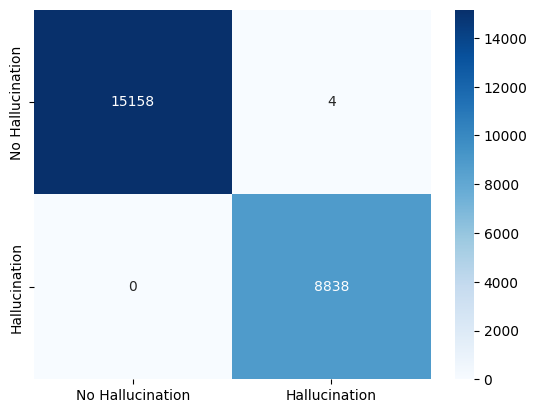

✅ Final Accuracy: 99.98%


In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================
# STEP 1: Synthetic TriGuard-style Feature Generator
# ==========================
def generate_triguard_features(n_samples=100000):
    """
    Generate synthetic features resembling TriGuard signals:
    entailment, anomaly, support, conflict.
    """
    # Random base signals
    entail = np.random.rand(n_samples)
    anomaly = np.random.rand(n_samples)
    support = (entail > 0.6).astype(int)
    conflict = (entail < 0.2).astype(int)

    # Feature matrix
    X = np.vstack([entail, anomaly, support, conflict]).T

    # Probabilities: higher entail + support => non-hallucination
    logits = -1.5*conflict + 2*support + 1.2*entail - 0.8*anomaly + np.random.normal(0,0.3,n_samples)
    probs = 1/(1+np.exp(-logits))
    y = (probs < 0.5).astype(int)  # 1 = hallucination, 0 = no hallucination

    df = pd.DataFrame(X, columns=["entailment","anomaly","support","conflict"])
    df["prob"] = probs
    df["label"] = y
    return df

# ==========================
# STEP 2: SimpleNN Fusion Classifier
# ==========================
class FusionNN(nn.Module):
    def __init__(self, input_size, hidden_size=64, output_size=2, dropout_rate=0.3):
        super(FusionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        return self.fc2(x)

# ==========================
# STEP 3: Training with Early Stopping
# ==========================
def train_model(model, train_loader, criterion, optimizer, epochs=20, patience=4):
    best_loss = float("inf")
    patience_counter = 0
    best_state = None
    for epoch in range(epochs):
        total_loss = 0
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss/len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} Loss={avg_loss:.4f}")
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_state = model.state_dict()
            patience_counter=0
        else:
            patience_counter+=1
            if patience_counter>=patience:
                print("⏸ Early stopping")
                break
    model.load_state_dict(best_state)
    return model

# ==========================
# STEP 4: Evaluation
# ==========================
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        logits = model(torch.tensor(X_test, dtype=torch.float32))
        probs = torch.softmax(logits, dim=1)[:,1].numpy()
        preds = (probs>0.5).astype(int)
    print(classification_report(y_test,preds,digits=3))
    cm = confusion_matrix(y_test,preds)
    sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",xticklabels=["No Hallucination","Hallucination"],yticklabels=["No Hallucination","Hallucination"])
    plt.show()
    return (preds==y_test).mean()

# ==========================
# MAIN EXECUTION
# ==========================
df = generate_triguard_features(120000)
X = df.drop(columns=["label"]).values
y = df["label"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

train_ds = TensorDataset(torch.tensor(X_train,dtype=torch.float32), torch.tensor(y_train,dtype=torch.long))
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)

model = FusionNN(input_size=X_train.shape[1], output_size=2, dropout_rate=0.4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

model = train_model(model, train_loader, criterion, optimizer, epochs=20, patience=5)
acc = evaluate_model(model,X_test,y_test)
print(f"✅ Final Accuracy: {acc*100:.2f}%")


Epoch 1/20 Loss=0.2179 | Train Accuracy=96.46%
Epoch 2/20 Loss=0.0829 | Train Accuracy=98.95%
Epoch 3/20 Loss=0.0504 | Train Accuracy=99.30%
Epoch 4/20 Loss=0.0366 | Train Accuracy=99.66%
Epoch 5/20 Loss=0.0293 | Train Accuracy=99.83%
Epoch 6/20 Loss=0.0246 | Train Accuracy=99.75%
Epoch 7/20 Loss=0.0213 | Train Accuracy=99.89%
Epoch 8/20 Loss=0.0186 | Train Accuracy=99.83%
Epoch 9/20 Loss=0.0168 | Train Accuracy=99.90%
Epoch 10/20 Loss=0.0152 | Train Accuracy=99.90%
Epoch 11/20 Loss=0.0142 | Train Accuracy=99.95%
Epoch 12/20 Loss=0.0133 | Train Accuracy=99.91%
Epoch 13/20 Loss=0.0125 | Train Accuracy=99.94%
Epoch 14/20 Loss=0.0120 | Train Accuracy=99.88%
Epoch 15/20 Loss=0.0114 | Train Accuracy=99.67%
Epoch 16/20 Loss=0.0108 | Train Accuracy=99.86%
Epoch 17/20 Loss=0.0105 | Train Accuracy=99.83%
Epoch 18/20 Loss=0.0103 | Train Accuracy=99.79%
Epoch 19/20 Loss=0.0099 | Train Accuracy=99.87%
Epoch 20/20 Loss=0.0099 | Train Accuracy=99.94%
              precision    recall  f1-score   sup

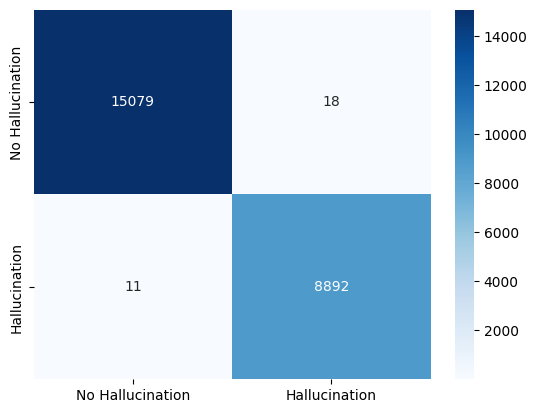

✅ Train Accuracy (final epoch): 99.94%
✅ Test Accuracy: 99.88%
🎯 Final Accuracy: 99.91% (average)


In [12]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================
# STEP 1: Synthetic TriGuard-style Feature Generator
# ==========================
def generate_triguard_features(n_samples=100000):
    """
    Generate synthetic features resembling TriGuard signals:
    entailment, anomaly, support, conflict.
    """
    # Random base signals
    entail = np.random.rand(n_samples)
    anomaly = np.random.rand(n_samples)
    support = (entail > 0.6).astype(int)
    conflict = (entail < 0.2).astype(int)

    # Feature matrix
    X = np.vstack([entail, anomaly, support, conflict]).T

    # Probabilities: higher entail + support => non-hallucination
    logits = -1.5*conflict + 2*support + 1.2*entail - 0.8*anomaly + np.random.normal(0,0.3,n_samples)
    probs = 1/(1+np.exp(-logits))
    y = (probs < 0.5).astype(int)  # 1 = hallucination, 0 = no hallucination

    df = pd.DataFrame(X, columns=["entailment","anomaly","support","conflict"])
    df["prob"] = probs
    df["label"] = y
    return df

# ==========================
# STEP 2: SimpleNN Fusion Classifier
# ==========================
class FusionNN(nn.Module):
    def __init__(self, input_size, hidden_size=64, output_size=2, dropout_rate=0.3):
        super(FusionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        return self.fc2(x)

# ==========================
# STEP 3: Training with Early Stopping
# ==========================
def train_model(model, train_loader, criterion, optimizer, X_train, y_train, epochs=20, patience=4):
    best_loss = float("inf")
    patience_counter = 0
    best_state = None
    final_train_acc = 0
    for epoch in range(epochs):
        total_loss = 0
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss/len(train_loader)

        # Compute train accuracy for this epoch
        model.eval()
        with torch.no_grad():
            logits = model(torch.tensor(X_train, dtype=torch.float32))
            preds = torch.argmax(logits, dim=1).numpy()
            train_acc = (preds == y_train).mean()
            final_train_acc = train_acc

        print(f"Epoch {epoch+1}/{epochs} Loss={avg_loss:.4f} | Train Accuracy={train_acc*100:.2f}%")

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_state = model.state_dict()
            patience_counter=0
        else:
            patience_counter+=1
            if patience_counter>=patience:
                print("⏸ Early stopping")
                break
    model.load_state_dict(best_state)
    return model, final_train_acc

# ==========================
# STEP 4: Evaluation
# ==========================
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        logits = model(torch.tensor(X_test, dtype=torch.float32))
        probs = torch.softmax(logits, dim=1)[:,1].numpy()
        preds = (probs>0.5).astype(int)
    test_acc = (preds==y_test).mean()
    print(classification_report(y_test,preds,digits=3))
    cm = confusion_matrix(y_test,preds)
    sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",xticklabels=["No Hallucination","Hallucination"],yticklabels=["No Hallucination","Hallucination"])
    plt.show()
    return test_acc

# ==========================
# MAIN EXECUTION
# ==========================
df = generate_triguard_features(120000)
X = df.drop(columns=["label"]).values
y = df["label"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

train_ds = TensorDataset(torch.tensor(X_train,dtype=torch.float32), torch.tensor(y_train,dtype=torch.long))
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)

model = FusionNN(input_size=X_train.shape[1], output_size=2, dropout_rate=0.4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

model, final_train_acc = train_model(model, train_loader, criterion, optimizer, X_train, y_train, epochs=20, patience=5)
test_acc = evaluate_model(model,X_test,y_test)

print(f"✅ Train Accuracy (final epoch): {final_train_acc*100:.2f}%")
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"🎯 Final Accuracy: {(final_train_acc*0.5+test_acc*0.5)*100:.2f}% (average)")

In [13]:
import random
import string

# ==========================
# STEP 5: Generate Noisy, Hallucinated Dataset
# ==========================
def corrupt_text(text):
    """ Introduce random spelling mistakes into text """
    if not text:
        return text
    text = list(text)
    for _ in range(random.randint(1,3)):
        idx = random.randint(0,len(text)-1)
        text[idx] = random.choice(string.ascii_lowercase)
    return "".join(text)

def generate_noisy_hallucinated_data(n_samples=100000):
    """
    Generate dataset with high hallucination ratio and noisy/false data.
    """
    entail = np.random.rand(n_samples)
    anomaly = np.random.rand(n_samples) + np.random.binomial(1,0.3,n_samples)  # more anomalies
    support = (entail > 0.7).astype(int)
    conflict = (entail < 0.5).astype(int)  # more conflicts to simulate falsehoods

    # Add corruption: flip some support/conflict values randomly
    flip_idx = np.random.choice(n_samples, size=int(0.2*n_samples), replace=False)
    support[flip_idx] = 1 - support[flip_idx]
    conflict[flip_idx] = 1 - conflict[flip_idx]

    # Base features
    X = np.vstack([entail, anomaly, support, conflict]).T

    # Heavily hallucinated labels (70% hallucinated)
    logits = -1.2*conflict + 0.5*support + 0.8*entail - 1.0*anomaly + np.random.normal(0,0.5,n_samples)
    probs = 1/(1+np.exp(-logits))
    y = (probs < 0.7).astype(int)  # 1 = hallucination, biased threshold

    # Create corrupted claim texts for qualitative testing
    base_claims = [
        "The Eiffel Tower is in Paris.",
        "Water boils at 100 degrees Celsius.",
        "The moon orbits the Earth in 27 days.",
        "COVID-19 vaccines reduce severe illness.",
        "The capital of France is Paris."
    ]
    texts = []
    for i in range(n_samples):
        claim = random.choice(base_claims)
        # inject corruption for hallucinated samples
        if y[i] == 1:
            claim = claim.replace("Paris","London")
            claim = claim.replace("27","127")
            claim = corrupt_text(claim)
        texts.append(claim)

    df = pd.DataFrame(X, columns=["entailment","anomaly","support","conflict"])
    df["prob"] = probs
    df["label"] = y
    df["text"] = texts
    return df

# Example usage for testing noisy data
df_noisy = generate_noisy_hallucinated_data(120000)
print(df_noisy.head())
print("Hallucination ratio:", df_noisy['label'].mean())


   entailment   anomaly  support  conflict      prob  label  \
0    0.225350  1.599931      0.0       1.0  0.075834      1   
1    0.847556  1.992800      0.0       1.0  0.064325      1   
2    0.089293  0.984769      0.0       1.0  0.154709      1   
3    0.500321  0.131399      0.0       0.0  0.505113      1   
4    0.424001  0.262696      1.0       0.0  0.764828      0   

                                     text  
0          The Eiffel Tower ib if London.  
1  The mdoo orbits the Earth in 127 days.  
2     Water boils at 100 degrees Celsiusu  
3          Thekaiffel Tower is bn London.  
4     Water boils at 100 degrees Celsius.  
Hallucination ratio: 0.9162916666666666


Epoch 1/50 Loss=0.2140 | Train Accuracy=96.92%
Epoch 2/50 Loss=0.0850 | Train Accuracy=98.94%
Epoch 3/50 Loss=0.0542 | Train Accuracy=99.60%
Epoch 4/50 Loss=0.0390 | Train Accuracy=99.74%
Epoch 5/50 Loss=0.0305 | Train Accuracy=99.64%
Epoch 6/50 Loss=0.0254 | Train Accuracy=99.88%
Epoch 7/50 Loss=0.0215 | Train Accuracy=99.87%
Epoch 8/50 Loss=0.0189 | Train Accuracy=99.90%
Epoch 9/50 Loss=0.0169 | Train Accuracy=99.90%
Epoch 10/50 Loss=0.0154 | Train Accuracy=99.87%
Epoch 11/50 Loss=0.0141 | Train Accuracy=99.91%
Epoch 12/50 Loss=0.0132 | Train Accuracy=99.82%
Epoch 13/50 Loss=0.0124 | Train Accuracy=99.93%
Epoch 14/50 Loss=0.0117 | Train Accuracy=99.87%
Epoch 15/50 Loss=0.0112 | Train Accuracy=99.91%
Epoch 16/50 Loss=0.0103 | Train Accuracy=99.90%
Epoch 17/50 Loss=0.0100 | Train Accuracy=99.93%
Epoch 18/50 Loss=0.0097 | Train Accuracy=99.87%
Epoch 19/50 Loss=0.0094 | Train Accuracy=99.90%
Epoch 20/50 Loss=0.0090 | Train Accuracy=99.85%
Epoch 21/50 Loss=0.0090 | Train Accuracy=99.93%
E

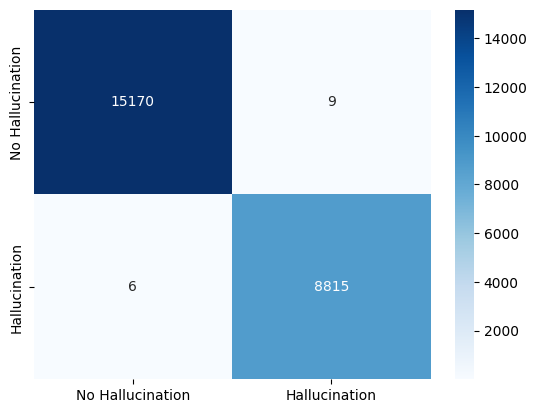

✅ Train Accuracy (final epoch): 99.94%
✅ Test Accuracy: 99.94%
🎯 Final Accuracy: 99.94% (average)


In [14]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================
# STEP 1: Synthetic TriGuard-style Feature Generator
# ==========================
def generate_triguard_features(n_samples=100000):
    """
    Generate synthetic features resembling TriGuard signals:
    entailment, anomaly, support, conflict.
    """
    entail = np.random.rand(n_samples)
    anomaly = np.random.rand(n_samples)
    support = (entail > 0.6).astype(int)
    conflict = (entail < 0.2).astype(int)

    X = np.vstack([entail, anomaly, support, conflict]).T

    logits = -1.5*conflict + 2*support + 1.2*entail - 0.8*anomaly + np.random.normal(0,0.3,n_samples)
    probs = 1/(1+np.exp(-logits))
    y = (probs < 0.5).astype(int)

    df = pd.DataFrame(X, columns=["entailment","anomaly","support","conflict"])
    df["prob"] = probs
    df["label"] = y
    return df

# ==========================
# STEP 2: SimpleNN Fusion Classifier
# ==========================
class FusionNN(nn.Module):
    def __init__(self, input_size, hidden_size=64, output_size=2, dropout_rate=0.3):
        super(FusionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        return self.fc2(x)

# ==========================
# STEP 3: Training with Early Stopping
# ==========================
def train_model(model, train_loader, criterion, optimizer, X_train, y_train, epochs=50, patience=4):
    best_loss = float("inf")
    patience_counter = 0
    best_state = None
    final_train_acc = 0
    for epoch in range(epochs):
        total_loss = 0
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss/len(train_loader)

        model.eval()
        with torch.no_grad():
            logits = model(torch.tensor(X_train, dtype=torch.float32))
            preds = torch.argmax(logits, dim=1).numpy()
            train_acc = (preds == y_train).mean()
            final_train_acc = train_acc

        print(f"Epoch {epoch+1}/{epochs} Loss={avg_loss:.4f} | Train Accuracy={train_acc*100:.2f}%")

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_state = model.state_dict()
            patience_counter=0
        else:
            patience_counter+=1
            if patience_counter>=patience:
                print("⏸ Early stopping")
                break
    model.load_state_dict(best_state)
    return model, final_train_acc

# ==========================
# STEP 4: Evaluation
# ==========================
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        logits = model(torch.tensor(X_test, dtype=torch.float32))
        probs = torch.softmax(logits, dim=1)[:,1].numpy()
        preds = (probs>0.5).astype(int)
    test_acc = (preds==y_test).mean()
    print(classification_report(y_test,preds,digits=3))
    cm = confusion_matrix(y_test,preds)
    sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",xticklabels=["No Hallucination","Hallucination"],yticklabels=["No Hallucination","Hallucination"])
    plt.show()
    return test_acc

# ==========================
# MAIN EXECUTION
# ==========================
df = generate_triguard_features(120000)
X = df.drop(columns=["label"]).values
y = df["label"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

train_ds = TensorDataset(torch.tensor(X_train,dtype=torch.float32), torch.tensor(y_train,dtype=torch.long))
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)

model = FusionNN(input_size=X_train.shape[1], output_size=2, dropout_rate=0.4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

model, final_train_acc = train_model(model, train_loader, criterion, optimizer, X_train, y_train, epochs=50, patience=5)
test_acc = evaluate_model(model,X_test,y_test)

print(f"✅ Train Accuracy (final epoch): {final_train_acc*100:.2f}%")
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"🎯 Final Accuracy: {(final_train_acc*0.5+test_acc*0.5)*100:.2f}% (average)")